In [ ]:
!pip install jiwer
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 52.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 20.8 MB/s eta 0:00:00


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import ast
from collections import Counter
from typing import List, Dict, Tuple
import random

# Preprocessing

In [ ]:
import re
import json
import random
from pathlib import Path

# Operators and punctuation (multi-char first)
MULTI_CHAR_OPS = [
    '==', '!=', '<=', '>=', '++', '--', '+=', '-=', '*=', '/=', '%=', '&&', '||', '<<', '>>', '->', '::', '...'
]
# Single char symbols
SINGLE_CHAR_SYMS = list("#{}()[].,;<>+-*/=%&|^~!:?")

# Build regex pattern
# 1. String literals
# 2. Multi-char ops
# 3. Single-char symbols
# 4. Identifiers
# 5. Numbers
TOKEN_PATTERN = re.compile(
    r'''
    "(?:[^"\\]|\\.)*"             |   # double-quoted string literals
    '(?:[^'\\]|\\.)*'             |   # single-quoted char literals
    ''' + '|'.join(re.escape(op) for op in MULTI_CHAR_OPS) + r''' |   # multi-char operators
    [''' + re.escape(''.join(SINGLE_CHAR_SYMS)) + r'''] |             # single-char symbols
    [A-Za-z_]\w*                  |   # identifiers
    \d+(?:\.\d+)?                     # numbers
    ''', re.VERBOSE
)

# Regex to remove comments
LINE_COMMENT = re.compile(r'//.*')
BLOCK_COMMENT = re.compile(r'/\*.*?\*/', re.DOTALL)

def tokenize_code_line(line: str):
    # Remove comments
    line = BLOCK_COMMENT.sub('', line)
    line = LINE_COMMENT.sub('', line)

    # Replace escaped newlines/tabs with space
    line = line.replace("\\n", " ").replace("\\t", " ").replace("\\r", " ")

    # Collapse multiple spaces
    line = re.sub(r'\s+', ' ', line).strip()
    if not line:
        return []

    # Find tokens
    tokens = [m.group(0) for m in TOKEN_PATTERN.finditer(line)]
    return tokens

def process_file(input_path: Path, output_path: Path):
    tokenized_lines = []
    with input_path.open("r", encoding="utf-8") as f:
        for line in f:
            tokens = tokenize_code_line(line)
            if tokens:
                tokenized_lines.append(tokens)

    with output_path.open("w", encoding="utf-8") as f:
        for tokens in tokenized_lines:
            f.write(json.dumps(tokens) + "\n")

    return tokenized_lines

def split_and_save(token_lists, base_name: str, train_ratio=0.8, val_ratio=0.1):
    random.shuffle(token_lists)
    n = len(token_lists)
    train_end = int(n * train_ratio)
    val_end = int(n * (train_ratio + val_ratio))
    splits = {
        'train': token_lists[:train_end],
        'val': token_lists[train_end:val_end],
        'test': token_lists[val_end:]
    }

    for split_name, data in splits.items():
        path = f"{base_name}_{split_name}.txt"
        with open(path, "w", encoding="utf-8") as f:
            for tokens in data:
                f.write(json.dumps(tokens) + "\n")

if __name__ == "__main__":
    # Input files
    c_tokens = process_file(Path("unpaired_c.txt"), Path("c_processed.txt"))
    cpp_tokens = process_file(Path("unpaired_c++.txt"), Path("cpp_processed.txt"))

    # Create train/val/test splits
    split_and_save(c_tokens, "c_code")
    split_and_save(cpp_tokens, "cpp_code")

    print("✅ Done! Tokenized long code lines correctly and created train/val/test splits.")

✅ Done! Tokenized long code lines correctly and created train/val/test splits.


# Metrics

In [ ]:
from torchmetrics.text import BLEUScore
from jiwer import wer, cer

class MetricsCalculator:
    """
    Calculate BLEU, CER, and WER metrics for sequence reconstruction.
    """
    def __init__(self, idx_to_token: Dict[int, str], pad_idx: int = 0):
        self.idx_to_token = idx_to_token
        self.pad_idx = pad_idx

        # Initialize BLEU calculator
        self.bleu_calculator = BLEUScore(n_gram=4)

    def indices_to_tokens(self, indices: torch.Tensor) -> List[List[str]]:
        """
        Convert token indices to list of token strings.

        Args:
            indices: (batch_size, seq_len)

        Returns:
            List of token lists for each sequence
        """
        batch_sequences = []
        for seq in indices:
            tokens = []
            for idx in seq:
                idx_val = idx.item()
                if idx_val != self.pad_idx:  # Skip padding
                    tokens.append(self.idx_to_token.get(idx_val, '<UNK>'))
            batch_sequences.append(tokens)
        return batch_sequences

    def tokens_to_string(self, tokens: List[str]) -> str:
        """Join tokens into a single string."""
        return ' '.join(tokens)

    def calculate_bleu(self, predictions: torch.Tensor, targets: torch.Tensor) -> float:
        """
        Calculate BLEU score.

        Args:
            predictions: (batch_size, seq_len) - predicted token indices
            targets: (batch_size, seq_len) - target token indices

        Returns:
            BLEU score (0-1)
        """
        # Convert indices to tokens
        pred_tokens = self.indices_to_tokens(predictions)
        target_tokens = self.indices_to_tokens(targets)

        # Convert to strings for BLEU calculation
        pred_strings = [self.tokens_to_string(tokens) for tokens in pred_tokens]
        target_strings = [[self.tokens_to_string(tokens)] for tokens in target_tokens]

        # Calculate BLEU
        try:
            bleu_score = self.bleu_calculator(pred_strings, target_strings)
            return bleu_score.item()
        except:
            return 0.0

    def calculate_cer(self, predictions: torch.Tensor, targets: torch.Tensor) -> float:
        """
        Calculate Character Error Rate (CER).

        Args:
            predictions: (batch_size, seq_len) - predicted token indices
            targets: (batch_size, seq_len) - target token indices

        Returns:
            CER score (lower is better, 0 is perfect)
        """
        # Convert indices to tokens
        pred_tokens = self.indices_to_tokens(predictions)
        target_tokens = self.indices_to_tokens(targets)

        # Convert to strings
        pred_strings = [self.tokens_to_string(tokens) for tokens in pred_tokens]
        target_strings = [self.tokens_to_string(tokens) for tokens in target_tokens]

        # Calculate CER for each pair and average
        try:
            cer_scores = []
            for pred, target in zip(pred_strings, target_strings):
                if len(target) > 0:  # Avoid empty references
                    cer_score = cer(target, pred)
                    cer_scores.append(cer_score)

            return np.mean(cer_scores) if cer_scores else 0.0
        except:
            return 0.0

    def calculate_wer(self, predictions: torch.Tensor, targets: torch.Tensor) -> float:
        """
        Calculate Word Error Rate (WER).

        Args:
            predictions: (batch_size, seq_len) - predicted token indices
            targets: (batch_size, seq_len) - target token indices

        Returns:
            WER score (lower is better, 0 is perfect)
        """
        # Convert indices to tokens
        pred_tokens = self.indices_to_tokens(predictions)
        target_tokens = self.indices_to_tokens(targets)

        # Convert to strings
        pred_strings = [self.tokens_to_string(tokens) for tokens in pred_tokens]
        target_strings = [self.tokens_to_string(tokens) for tokens in target_tokens]

        # Calculate WER for each pair and average
        try:
            wer_scores = []
            for pred, target in zip(pred_strings, target_strings):
                if len(target.split()) > 0:  # Avoid empty references
                    wer_score = wer(target, pred)
                    wer_scores.append(wer_score)

            return np.mean(wer_scores) if wer_scores else 0.0
        except:
            return 0.0

    def calculate_all_metrics(self, predictions: torch.Tensor, targets: torch.Tensor) -> Dict[str, float]:
        """
        Calculate all metrics (BLEU, CER, WER).

        Args:
            predictions: (batch_size, seq_len) - predicted token indices
            targets: (batch_size, seq_len) - target token indices

        Returns:
            Dictionary with all metrics
        """
        return {
            'bleu': self.calculate_bleu(predictions, targets),
            'cer': self.calculate_cer(predictions, targets),
            'wer': self.calculate_wer(predictions, targets)
        }

# Model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class Encoder(nn.Module):
    """Transformer Encoder using PyTorch's built-in TransformerEncoder."""

    def __init__(self, vocab_size, d_model=512, nhead=8, num_layers=6,
                 dim_feedforward=2048, dropout=0.1, max_len=5000):
        super().__init__()

        self.d_model = d_model
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model, max_len)

        # Using PyTorch's built-in TransformerEncoderLayer
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )

        # Stack multiple encoder layers
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src, src_mask=None, src_key_padding_mask=None):
        """
        Args:
            src: (batch_size, seq_len)
            src_mask: (seq_len, seq_len) - attention mask
            src_key_padding_mask: (batch_size, seq_len) - padding mask
        """
        # Embedding with scaling
        src = self.embedding(src) * math.sqrt(self.d_model)

        # Add positional encoding
        src = src.transpose(0, 1)  # (seq_len, batch_size, d_model)
        src = self.pos_encoder(src)
        src = src.transpose(0, 1)  # Back to (batch_size, seq_len, d_model)
        src = self.dropout(src)

        # Pass through transformer encoder
        output = self.transformer_encoder(
            src,
            mask=src_mask,
            src_key_padding_mask=src_key_padding_mask
        )

        return output

class Decoder(nn.Module):
    """Transformer Decoder using PyTorch's built-in TransformerDecoder."""

    def __init__(self, vocab_size, d_model=512, nhead=8, num_layers=6, dim_feedforward=2048, dropout=0.1, max_len=5000):
        super().__init__()

        self.d_model = d_model
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model, max_len)

        # Using PyTorch's built-in TransformerDecoderLayer
        decoder_layer = nn.TransformerDecoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )

        # Stack multiple decoder layers
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers)
        self.dropout = nn.Dropout(dropout)
        self.output_projection = nn.Linear(d_model, vocab_size)

    def forward(self, tgt, memory, tgt_mask=None, memory_mask=None, tgt_key_padding_mask=None, memory_key_padding_mask=None):
        """
        Args:
            tgt: (batch_size, tgt_seq_len)
            memory: (batch_size, src_seq_len, d_model) - encoder output
            tgt_mask: (tgt_seq_len, tgt_seq_len) - causal mask
            memory_mask: (tgt_seq_len, src_seq_len) - cross attention mask
            tgt_key_padding_mask: (batch_size, tgt_seq_len) - target padding mask
            memory_key_padding_mask: (batch_size, src_seq_len) - source padding mask
        """
        # Embedding with scaling
        tgt = self.embedding(tgt) * math.sqrt(self.d_model)

        # Add positional encoding
        tgt = tgt.transpose(0, 1)  # (seq_len, batch_size, d_model)
        tgt = self.pos_encoder(tgt)
        tgt = tgt.transpose(0, 1)  # Back to (batch_size, seq_len, d_model)
        tgt = self.dropout(tgt)

        # Pass through transformer decoder
        output = self.transformer_decoder(
            tgt=tgt,
            memory=memory,
            tgt_mask=tgt_mask,
            memory_mask=memory_mask,
            tgt_key_padding_mask=tgt_key_padding_mask,
            memory_key_padding_mask=memory_key_padding_mask
        )

        # Project to vocabulary size
        output = self.output_projection(output)

        return output


class Model1(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model=512, nhead=8,
                 num_encoder_layers=6, num_decoder_layers=6, dim_feedforward=2048,
                 dropout=0.1, max_len=5000):
        super().__init__()

        self.encoder = Encoder(
            vocab_size=src_vocab_size,
            d_model=d_model,
            nhead=nhead,
            num_layers=num_encoder_layers,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            max_len=max_len
        )

        self.decoder1 = Decoder(
            vocab_size=tgt_vocab_size,
            d_model=d_model,
            nhead=nhead,
            num_layers=num_decoder_layers,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            max_len=max_len
        )


        self.decoder2 = Decoder(
            vocab_size=tgt_vocab_size,
            d_model=d_model,
            nhead=nhead,
            num_layers=num_decoder_layers,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            max_len=max_len
        )

    def forward(self, src, tgt, flag, src_mask=None, tgt_mask=None, memory_mask=None, src_key_padding_mask=None, tgt_key_padding_mask=None, memory_key_padding_mask=None):

        # Encode source sequence
        memory = self.encoder(
            src=src,
            src_mask=src_mask,
            src_key_padding_mask=src_key_padding_mask
        )

        if flag:    # for switching between 2 languages
            output = self.decoder1(
                tgt=tgt,
                memory=memory,
                tgt_mask=tgt_mask,
                memory_mask=memory_mask,
                tgt_key_padding_mask=tgt_key_padding_mask,
                memory_key_padding_mask=memory_key_padding_mask
            )

        else:
            output = self.decoder2(
                tgt=tgt,
                memory=memory,
                tgt_mask=tgt_mask,
                memory_mask=memory_mask,
                tgt_key_padding_mask=tgt_key_padding_mask,
                memory_key_padding_mask=memory_key_padding_mask
            )

        return output

In [ ]:
class PositionalEncoding(nn.Module):
    """Positional encoding for transformer inputs."""

    def __init__(self, d_model, max_len=5000):
        super().__init__()

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)

        div_term = torch.exp(torch.arange(0, d_model, 2).float() *
                           (-math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)

        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(0), :]


In [ ]:
# Utility functions for creating masks
def generate_square_subsequent_mask(sz):
    """Generate a square mask for the sequence to prevent attention to future positions."""
    mask = torch.triu(torch.ones(sz, sz) * float('-inf'), diagonal=1)
    return mask

# Data Loaders

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import ast
from collections import Counter
from typing import List, Dict, Tuple
import random

class TokenizedCodeDataset(Dataset):

    def __init__(self, file_path: str, max_seq_len: int = 512, min_seq_len: int = 5,
                 vocab_size: int = None, test_mode: bool = False, vocab: List[str] = None):
        """
        Args:
            file_path: Path to tokenized text file
            max_seq_len: Maximum sequence length (longer sequences will be truncated)
            min_seq_len: Minimum sequence length (shorter sequences will be filtered)
            vocab_size: Maximum vocabulary size (None for no limit)
            test_mode: If True, loads only first 1000 lines for testing
        """
        self.max_seq_len = max_seq_len
        self.min_seq_len = min_seq_len

        # Special tokens
        self.PAD_TOKEN = '<PAD>'
        self.UNK_TOKEN = '<UNK>'
        self.SOS_TOKEN = '<SOS>'  # Start of sequence
        self.EOS_TOKEN = '<EOS>'  # End of sequence

        # Load and process data
        self.sequences = self._load_data(file_path, test_mode)
        if vocab is None:
            # Build vocab from this dataset
            self.vocab = self._build_vocab(vocab_size)
        else:
            # Use given vocab (shared across datasets)
            self.vocab = vocab
        self.token_to_idx = {token: idx for idx, token in enumerate(self.vocab)}
        self.idx_to_token = {idx: token for token, idx in self.token_to_idx.items()}

        # Convert sequences to indices
        self.encoded_sequences = self._encode_sequences()

        print(f"Loaded {len(self.encoded_sequences)} sequences")
        print(f"Vocabulary size: {len(self.vocab)}")
        print(f"Average sequence length: {sum(len(seq) for seq in self.sequences) / len(self.sequences):.1f}")

    def _load_data(self, file_path: str, test_mode: bool) -> List[List[str]]:
        """Load tokenized sequences from file where each line looks like ["#", "include", "<"]."""
        sequences = []

        with open(file_path, 'r', encoding='utf-8') as f:
            for i, line in enumerate(f):
                if test_mode and i >= 1000:  # Limit for testing
                    break

                line = line.strip()
                if not line:
                    continue

                try:
                    # Parse the list of tokens from string representation
                    tokens = ast.literal_eval(line)

                    # Ensure it's a list of strings
                    if isinstance(tokens, list) and len(tokens) >= self.min_seq_len:
                        # Convert everything to string (in case of numbers or symbols)
                        tokens = [str(token) for token in tokens]

                        # Truncate if needed (reserve space for SOS/EOS)
                        if len(tokens) > self.max_seq_len - 2:
                            tokens = tokens[: self.max_seq_len - 2]

                        sequences.append(tokens)

                except (ValueError, SyntaxError) as e:
                    print(f"Skipping line {i+1}: {e}")
                    continue

        if not sequences:
            raise ValueError("No valid sequences found in the file!")

        return sequences


    def _build_vocab(self, vocab_size: int = None, min_freq: int = 3) -> List[str]:
        """Build vocabulary from all tokens with frequency threshold."""
        # Count all tokens
        token_counts = Counter()
        for sequence in self.sequences:
            token_counts.update(sequence)

        # Start with special tokens
        vocab = [self.PAD_TOKEN, self.UNK_TOKEN, self.SOS_TOKEN, self.EOS_TOKEN]

        # Filter tokens by frequency (only keep tokens with count >= min_freq)
        filtered_tokens = [(tok, cnt) for tok, cnt in token_counts.items() if cnt >= min_freq]

        # Sort by frequency (most common first)
        filtered_tokens.sort(key=lambda x: x[1], reverse=True)

        # Apply vocab size limit if given
        if vocab_size is not None:
            remaining_vocab_size = vocab_size - len(vocab)
            filtered_tokens = filtered_tokens[:remaining_vocab_size]

        # Add to vocab
        vocab.extend([tok for tok, _ in filtered_tokens])

        return vocab

    def _encode_sequences(self) -> List[List[int]]:
        """Convert token sequences to index sequences, replace rare tokens with <UNK>."""
        encoded = []
        unk_idx = self.token_to_idx[self.UNK_TOKEN]
        sos_idx = self.token_to_idx[self.SOS_TOKEN]
        eos_idx = self.token_to_idx[self.EOS_TOKEN]

        for sequence in self.sequences:
            # Add SOS and EOS tokens
            full_sequence = [self.SOS_TOKEN] + sequence + [self.EOS_TOKEN]

            # Convert to indices, replace unknown tokens with <UNK>
            indices = []
            for token in full_sequence:
                indices.append(self.token_to_idx.get(token, unk_idx))

            encoded.append(indices)

        return encoded

    def __len__(self) -> int:
        return len(self.encoded_sequences)

    def __getitem__(self, idx: int) -> Dict[str, torch.Tensor]:
        """
        Return source and target sequences for reconstruction.
        For unsupervised learning, target is the same as source but shifted.
        """
        sequence = self.encoded_sequences[idx]

        # For encoder-decoder reconstruction:
        # Source: full sequence with SOS and EOS
        # Target input: sequence without EOS (for teacher forcing)
        # Target output: sequence without SOS (for loss calculation)

        src_seq = torch.tensor(sequence, dtype=torch.long)
        tgt_input = torch.tensor(sequence[:-1], dtype=torch.long)  # Remove EOS
        tgt_output = torch.tensor(sequence[1:], dtype=torch.long)  # Remove SOS

        return {
            'src': src_seq,           # Input to encoder
            'tgt_input': tgt_input,   # Input to decoder (with teacher forcing)
            'tgt_output': tgt_output, # Target for loss calculation
            'src_len': len(src_seq),
            'tgt_len': len(tgt_input)
        }

def collate_fn(batch: List[Dict]) -> Dict[str, torch.Tensor]:
    """
    Collate function to pad sequences in a batch.
    """
    # Separate different components
    src_seqs = [item['src'] for item in batch]
    tgt_input_seqs = [item['tgt_input'] for item in batch]
    tgt_output_seqs = [item['tgt_output'] for item in batch]
    src_lens = torch.tensor([item['src_len'] for item in batch])
    tgt_lens = torch.tensor([item['tgt_len'] for item in batch])

    # Pad sequences
    src_padded = pad_sequence(src_seqs, batch_first=True, padding_value=0)  # PAD token is at index 0
    tgt_input_padded = pad_sequence(tgt_input_seqs, batch_first=True, padding_value=0)
    tgt_output_padded = pad_sequence(tgt_output_seqs, batch_first=True, padding_value=0)

    # Create padding masks (True for real tokens, False for padding)
    src_mask = (src_padded != 0)
    tgt_mask = (tgt_input_padded != 0)

    return {
        'src': src_padded,
        'tgt_input': tgt_input_padded,
        'tgt_output': tgt_output_padded,
        'src_mask': src_mask,
        'tgt_mask': tgt_mask,
        'src_lens': src_lens,
        'tgt_lens': tgt_lens
    }

def create_dataloader(file_path: str, batch_size: int = 32, shuffle: bool = True,
                     max_seq_len: int = 512, min_seq_len: int = 5,
                     vocab_size: int = None, test_mode: bool = False,
                     num_workers: int = 0, vocab: List[str] = None) -> Tuple[DataLoader, TokenizedCodeDataset]:
    """
    Create a DataLoader for the tokenized code dataset.

    Args:
        file_path: Path to the tokenized text file
        batch_size: Batch size for training
        shuffle: Whether to shuffle the dataset
        max_seq_len: Maximum sequence length
        min_seq_len: Minimum sequence length
        vocab_size: Maximum vocabulary size
        test_mode: Load only subset for testing
        num_workers: Number of workers for data loading

    Returns:
        DataLoader and Dataset objects
    """

    # Create dataset
    dataset = TokenizedCodeDataset(
        file_path=file_path,
        max_seq_len=max_seq_len,
        min_seq_len=min_seq_len,
        vocab_size=vocab_size,
        test_mode=test_mode,
        vocab = vocab
    )

    # Create dataloader
    dataloader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        collate_fn=collate_fn,
        num_workers=num_workers,
        pin_memory=True if torch.cuda.is_available() else False
    )

    return dataloader, dataset

# **Trainer**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import math
import time
from typing import Dict, Tuple
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import os

class ReconstructionLoss(nn.Module):
    """
    Reconstruction loss for sequence-to-sequence learning.
    Uses CrossEntropyLoss with padding token masking.
    """

    def __init__(self, vocab_size: int, pad_idx: int = 0, label_smoothing: float = 0.0):
        super().__init__()
        self.vocab_size = vocab_size
        self.pad_idx = pad_idx
        self.criterion = nn.CrossEntropyLoss(
            ignore_index=pad_idx,  # Ignore padding tokens in loss
            label_smoothing=label_smoothing
        )

    def forward(self, predictions: torch.Tensor, targets: torch.Tensor,
                target_mask: torch.Tensor = None) -> Dict[str, torch.Tensor]:
        """
        Calculate reconstruction loss.

        Args:
            predictions: (batch_size, seq_len, vocab_size)
            targets: (batch_size, seq_len)
            target_mask: (batch_size, seq_len) - True for real tokens

        Returns:
            Dictionary with loss and metrics
        """
        batch_size, seq_len, vocab_size = predictions.shape

        # Reshape for CrossEntropyLoss
        predictions_flat = predictions.view(-1, vocab_size)  # (batch_size * seq_len, vocab_size)
        targets_flat = targets.view(-1)  # (batch_size * seq_len,)

        # Calculate loss
        loss = self.criterion(predictions_flat, targets_flat)

        # Calculate accuracy (only for non-padding tokens)
        with torch.no_grad():
            pred_tokens = torch.argmax(predictions_flat, dim=-1)

            if target_mask is not None:
                mask_flat = target_mask.view(-1)
                correct = ((pred_tokens == targets_flat) & mask_flat).sum().float()
                total = mask_flat.sum().float()
            else:
                # Use ignore_index to exclude padding tokens
                valid_mask = targets_flat != self.pad_idx
                correct = ((pred_tokens == targets_flat) & valid_mask).sum().float()
                total = valid_mask.sum().float()

            accuracy = correct / (total + 1e-8)  # Avoid division by zero

        # Calculate perplexity
        perplexity = torch.exp(loss)

        return {
            'loss': loss,
            'accuracy': accuracy,
            'perplexity': perplexity,
            'num_tokens': total
        }

def generate_square_subsequent_mask(sz: int, device: torch.device) -> torch.Tensor:
    """Generate causal mask for decoder self-attention."""
    mask = torch.triu(torch.ones(sz, sz, device=device) * float('-inf'), diagonal=1)
    return mask

def create_padding_mask(seq: torch.Tensor, pad_idx: int = 0) -> torch.Tensor:
    """Create padding mask - True for padding tokens."""
    return (seq == pad_idx)

class TransformerTrainer:
    """
    Trainer class for Transformer reconstruction training.
    """

    def __init__(self, model: nn.Module, vocab_size: int, idx_to_token: Dict[int, str], pad_idx: int = 0,
                 learning_rate: float = 1e-4, weight_decay: float = 1e-5,
                 label_smoothing: float = 0.1, warmup_steps: int = 4000):

        self.model = model
        self.vocab_size = vocab_size
        self.pad_idx = pad_idx
        self.device = next(model.parameters()).device

        # Loss function
        self.criterion = ReconstructionLoss(vocab_size, pad_idx, label_smoothing)

        # Optimizer with learning rate scheduling
        self.optimizer = optim.AdamW(
            model.parameters(),
            lr=learning_rate,
            betas=(0.9, 0.98),
            weight_decay=weight_decay
        )

        self.metrics_calculator = MetricsCalculator(idx_to_token, pad_idx)

        # Learning rate scheduler (Transformer-style warmup)
        self.warmup_steps = warmup_steps
        self.d_model = model.encoder.d_model if hasattr(model.encoder, 'd_model') else 512
        self.scheduler = optim.lr_scheduler.LambdaLR(
            self.optimizer,
            lr_lambda=self._get_lr_scale
        )

        # Training metrics
        self.train_losses_1 = []
        self.train_losses_2 = []
        self.train_accuracies_1 = []
        self.train_accuracies_2 = []
        self.val_losses_1 = []
        self.val_losses_2 = []
        self.val_accuracies_1 = []
        self.val_accuracies_2 = []
        self.val_bleu_1 = []
        self.val_bleu_2 = []
        self.val_cer_1 = []
        self.val_cer_2 = []
        self.val_wer_1 = []
        self.val_wer_2 = []
        self.step = 0

    def _get_lr_scale(self, step: int) -> float:
        """Learning rate scaling for warmup."""
        step = max(1, step)  # Avoid division by zero
        return (self.d_model ** -0.5) * min(step ** -0.5, step * (self.warmup_steps ** -1.5))

    def train_step(self, batch: Dict[str, torch.Tensor], flag: bool) -> Dict[str, float]:
        """Single training step."""
        self.model.train()
        self.optimizer.zero_grad()

        # Move batch to device
        src = batch['src'].to(self.device)
        tgt_input = batch['tgt_input'].to(self.device)
        tgt_output = batch['tgt_output'].to(self.device)
        tgt_mask_padding = batch['tgt_mask'].to(self.device)

        batch_size, tgt_len = tgt_input.shape

        # Create masks
        src_key_padding_mask = create_padding_mask(src, self.pad_idx)
        tgt_key_padding_mask = create_padding_mask(tgt_input, self.pad_idx)
        tgt_mask = generate_square_subsequent_mask(tgt_len, self.device)

        # Forward pass
        output = self.model(
            src=src,
            tgt=tgt_input,
            flag = flag,
            tgt_mask=tgt_mask,
            src_key_padding_mask=src_key_padding_mask,
            tgt_key_padding_mask=tgt_key_padding_mask,
            memory_key_padding_mask=src_key_padding_mask
        )

        # Calculate loss
        loss_dict = self.criterion(output, tgt_output, tgt_mask_padding)
        loss = loss_dict['loss']

        # Backward pass
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)

        # Update parameters
        self.optimizer.step()
        self.scheduler.step()
        self.step += 1



        return {
            'loss': loss.item(),
            'accuracy': loss_dict['accuracy'].item(),
            'perplexity': loss_dict['perplexity'].item(),
            'lr': self.scheduler.get_last_lr()[0],
            'num_tokens': loss_dict['num_tokens'].item()
        }

    def validate(self, val_loader_1: DataLoader, val_loader_2: DataLoader) -> Dict[str, float]:
        """Validation loop."""
        self.model.eval()

        total_loss_1 = 0
        total_accuracy_1 = 0
        total_tokens_1 = 0
        total_bleu_1 = 0
        total_cer_1 = 0
        total_wer_1 = 0

        total_loss_2 = 0
        total_accuracy_2 = 0
        total_tokens_2 = 0
        total_bleu_2 = 0
        total_cer_2 = 0
        total_wer_2 = 0

        num_batches = 0

        with torch.no_grad():
            for batch_1, batch_2 in tqdm(zip(val_loader_1, val_loader_2), desc="Validating", leave=False):
                # Move batch to device
                src_1 = batch_1['src'].to(self.device)
                tgt_input_1 = batch_1['tgt_input'].to(self.device)
                tgt_output_1 = batch_1['tgt_output'].to(self.device)
                tgt_mask_padding_1 = batch_1['tgt_mask'].to(self.device)

                src_2 = batch_2['src'].to(self.device)
                tgt_input_2 = batch_2['tgt_input'].to(self.device)
                tgt_output_2 = batch_2['tgt_output'].to(self.device)
                tgt_mask_padding_2 = batch_2['tgt_mask'].to(self.device)

                batch_size, tgt_len_1 = tgt_input_1.shape
                batch_size, tgt_len_2 = tgt_input_2.shape

                # Create masks
                src_key_padding_mask_1 = create_padding_mask(src_1, self.pad_idx)
                tgt_key_padding_mask_1 = create_padding_mask(tgt_input_1, self.pad_idx)
                tgt_mask_1 = generate_square_subsequent_mask(tgt_len_1, self.device)

                src_key_padding_mask_2 = create_padding_mask(src_2, self.pad_idx)
                tgt_key_padding_mask_2 = create_padding_mask(tgt_input_2, self.pad_idx)
                tgt_mask_2 = generate_square_subsequent_mask(tgt_len_2, self.device)

                # Forward pass
                output_1 = self.model(
                    src=src_1,
                    tgt=tgt_input_1,
                    flag=True,
                    tgt_mask=tgt_mask_1,
                    src_key_padding_mask=src_key_padding_mask_1,
                    tgt_key_padding_mask=tgt_key_padding_mask_1,
                    memory_key_padding_mask=src_key_padding_mask_1
                )

                output_2 = self.model(
                    src=src_2,
                    tgt=tgt_input_2,
                    flag=False,
                    tgt_mask=tgt_mask_2,
                    src_key_padding_mask=src_key_padding_mask_2,
                    tgt_key_padding_mask=tgt_key_padding_mask_2,
                    memory_key_padding_mask=src_key_padding_mask_2
                )

                # Calculate loss
                loss_dict_1 = self.criterion(output_1, tgt_output_1, tgt_mask_padding_1)
                loss_dict_2 = self.criterion(output_2, tgt_output_2, tgt_mask_padding_2)

                predictions_1 = torch.argmax(output_1, dim=-1)
                predictions_2 = torch.argmax(output_2, dim=-1)

                metrics_1 = self.metrics_calculator.calculate_all_metrics(predictions_1, tgt_output_1)
                metrics_2 = self.metrics_calculator.calculate_all_metrics(predictions_2, tgt_output_2)

                # Accumulate metrics
                total_loss_1 += loss_dict_1['loss'].item()
                total_accuracy_1 += loss_dict_1['accuracy'].item() * loss_dict_1['num_tokens'].item()
                total_tokens_1 += loss_dict_1['num_tokens'].item()
                total_bleu_1 += metrics_1['bleu']
                total_cer_1 += metrics_1['cer']
                total_wer_1 += metrics_1['wer']

                total_loss_2 += loss_dict_2['loss'].item()
                total_accuracy_2 += loss_dict_2['accuracy'].item() * loss_dict_2['num_tokens'].item()
                total_tokens_2 += loss_dict_2['num_tokens'].item()
                total_bleu_2 += metrics_2['bleu']
                total_cer_2 += metrics_2['cer']
                total_wer_2 += metrics_2['wer']

                num_batches += 1

        avg_loss_1 = total_loss_1 / num_batches
        avg_accuracy_1 = total_accuracy_1 / total_tokens_1 if total_tokens_1 > 0 else 0
        avg_perplexity_1 = math.exp(avg_loss_1)
        avg_bleu_1 = total_bleu_1 / num_batches
        avg_cer_1 = total_cer_1 / num_batches
        avg_wer_1 = total_wer_1 / num_batches

        avg_loss_2 = total_loss_2 / num_batches
        avg_accuracy_2 = total_accuracy_2 / total_tokens_2 if total_tokens_2 > 0 else 0
        avg_perplexity_2 = math.exp(avg_loss_2)
        avg_bleu_2 = total_bleu_2 / num_batches
        avg_cer_2 = total_cer_2 / num_batches
        avg_wer_2 = total_wer_2 / num_batches

        return {
            'loss_1': avg_loss_1,
            'loss_2': avg_loss_2,
            'accuracy_1': avg_accuracy_1,
            'accuracy_2': avg_accuracy_2,
            'perplexity_1': avg_perplexity_1,
            'perplexity_2': avg_perplexity_2,
            'bleu_1': avg_bleu_1,
            'bleu_2': avg_bleu_2,
            'cer_1': avg_cer_1,
            'cer_2': avg_cer_2,
            'wer_1': avg_wer_1,
            'wer_2': avg_wer_2
        }

    def train_epoch(self, train_loader_1: DataLoader, train_loader_2: DataLoader, val_loader_1: DataLoader = None,
                   val_loader_2: DataLoader = None, print_every: int = 100) -> Dict[str, float]:
        """Train for one epoch."""

        epoch_loss_1 = 0
        epoch_loss_2 = 0
        epoch_accuracy_1 = 0
        epoch_accuracy_2 = 0
        epoch_tokens_1 = 0
        epoch_tokens_2 = 0

        progress_bar = tqdm(zip(train_loader_1, train_loader_2), desc="Training")

        for batch_idx, (batch_1, batch_2) in enumerate(progress_bar):
            # Training step
            metrics_1 = self.train_step(batch_1, flag = True)
            metrics_2 = self.train_step(batch_2, flag = False)

            # Accumulate metrics
            epoch_loss_1 += metrics_1['loss']
            epoch_loss_2 += metrics_2['loss']
            epoch_accuracy_1 += metrics_1['accuracy'] * metrics_1['num_tokens']
            epoch_accuracy_2 += metrics_2['accuracy'] * metrics_2['num_tokens']
            epoch_tokens_1 += metrics_1['num_tokens']

            # Update progress bar
            progress_bar.set_postfix({
                'loss_1': f"{metrics_1['loss']:.4f}",
                'loss_2': f"{metrics_2['loss']:.4f}",
                'acc_1': f"{metrics_1['accuracy']:.4f}",
                'acc_2': f"{metrics_2['accuracy']:.4f}",
                'lr': f"{metrics_1['lr']:.2e}",
                'ppl_1': f"{metrics_1['perplexity']:.2f}",
                'ppl_2': f"{metrics_2['perplexity']:.2f}"
            })

            # Print detailed stats
            if (batch_idx + 1) % print_every == 0:
                avg_loss_1 = epoch_loss_1 / (batch_idx + 1)
                avg_loss_2 = epoch_loss_2 / (batch_idx + 1)
                avg_acc_1 = epoch_accuracy_1 / epoch_tokens_1 if epoch_tokens_1 > 0 else 0
                avg_acc_2 = epoch_accuracy_2 / epoch_tokens_2 if epoch_tokens_2 > 0 else 0

                print(f"\nStep {self.step}, Batch {batch_idx + 1}/{len(train_loader_1)}")
                print(f"Loss 1: {avg_loss_1:.4f}, Accuracy: {avg_acc_1:.4f}")
                print(f"Loss 2: {avg_loss_2:.4f}, Accuracy: {avg_acc_2:.4f}")
                print(f"Learning Rate: {metrics_1['lr']:.2e}")

        # Calculate epoch averages
        avg_train_loss_1 = epoch_loss_1 / len(train_loader_1)
        avg_train_loss_2 = epoch_loss_2 / len(train_loader_2)
        avg_train_acc_1 = epoch_accuracy_1 / epoch_tokens_1 if epoch_tokens_1 > 0 else 0
        avg_train_acc_2 = epoch_accuracy_2 / epoch_tokens_2 if epoch_tokens_2 > 0 else 0

        # Validation
        val_metrics = {}
        if (val_loader_1 is not None) and (val_loader_2 is not None):
            print("\nRunning validation...")
            val_metrics = self.validate(val_loader_1, val_loader_2)

        # Store metrics
        self.train_losses_1.append(avg_train_loss_1)
        self.train_losses_2.append(avg_train_loss_2)
        self.train_accuracies_1.append(avg_train_acc_1)
        self.train_accuracies_2.append(avg_train_acc_2)
        if val_metrics:
            self.val_losses_1.append(val_metrics['loss_1'])
            self.val_losses_2.append(val_metrics['loss_2'])
            self.val_accuracies_1.append(val_metrics['accuracy_1'])
            self.val_accuracies_2.append(val_metrics['accuracy_2'])
            self.val_bleu_1.append(val_metrics['bleu_1'])
            self.val_bleu_2.append(val_metrics['bleu_2'])
            self.val_cer_1.append(val_metrics['cer_1'])
            self.val_cer_2.append(val_metrics['cer_2'])
            self.val_wer_1.append(val_metrics['wer_1'])
            self.val_wer_2.append(val_metrics['wer_2'])

        return {
            'train_loss_1': avg_train_loss_1,
            'train_loss_2': avg_train_loss_2,
            'train_accuracy_1': avg_train_acc_1,
            'train_accuracy_2': avg_train_acc_2,
            **val_metrics
        }

    def save_checkpoint(self, filepath: str, epoch: int, best_val_loss_1: float = None, best_val_loss_2: float = None):
        """Save model checkpoint."""
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'scheduler_state_dict': self.scheduler.state_dict(),
            'train_losses_1': self.train_losses_1,
            'train_losses_2': self.train_losses_2,
            'train_accuracies_1': self.train_accuracies_1,
            'train_accuracies_2': self.train_accuracies_2,
            'val_losses_1': self.val_losses_1,
            'val_losses_2': self.val_losses_2,
            'val_accuracies_1': self.val_accuracies_1,
            'val_accuracies_2': self.val_accuracies_2,
            'val_bleu_1': self.val_bleu_1,
            'val_bleu_2': self.val_bleu_2,
            'val_cer_1': self.val_cer_1,
            'val_cer_2': self.val_cer_2,
            'val_wer_1': self.val_wer_1,
            'val_wer_2': self.val_wer_2,
            'step': self.step,
            'best_val_loss_1': best_val_loss_1,
            'best_val_loss_2': best_val_loss_2
        }
        torch.save(checkpoint, filepath)

    def load_checkpoint(self, filepath: str):
        """Load model checkpoint."""
        checkpoint = torch.load(filepath, map_location=self.device)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        self.train_losses_1 = checkpoint.get('train_losses_1', [])
        self.train_losses_2 = checkpoint.get('train_losses_2', [])
        self.train_accuracies_1 = checkpoint.get('train_accuracies_1', [])
        self.train_accuracies_2 = checkpoint.get('train_accuracies_2', [])
        self.val_losses_1 = checkpoint.get('val_losses_1', [])
        self.val_losses_2 = checkpoint.get('val_losses_2', [])
        self.val_accuracies_1 = checkpoint.get('val_accuracies_1', [])
        self.val_accuracies_2 = checkpoint.get('val_accuracies_2', [])
        self.val_bleu_1 = checkpoint.get('val_bleu_1', [])
        self.val_bleu_2 = checkpoint.get('val_bleu_2', [])
        self.val_cer_1 = checkpoint.get('val_cer_1', [])
        self.val_cer_2 = checkpoint.get('val_cer_2', [])
        self.val_wer_1 = checkpoint.get('val_wer_1', [])
        self.val_wer_2 = checkpoint.get('val_wer_2', [])
        self.step = checkpoint.get('step', 0)
        return checkpoint.get('epoch', 0), checkpoint.get('best_val_loss_1', float('inf')), checkpoint.get('best_val_loss_2', float('inf'))

    def plot_metrics(self, save_path: str = None):
        """Plot training metrics."""
        fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(12, 4))

        epochs = range(1, len(self.train_losses_1) + 1)

        # Loss plot
        ax1.plot(epochs, self.train_losses_1, 'b-', label='Train Loss 1')
        ax1.plot(epochs, self.train_losses_2, 'c-', label='Train Loss 2')

        if self.val_losses_1:
            ax1.plot(epochs, self.val_losses_1, 'r-', label='Val Loss 1')
            ax1.plot(epochs, self.val_losses_2, 'g-', label='Val Loss 2')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.set_title('Training and Validation Loss')
        ax1.legend()
        ax1.grid(True)

        # Accuracy plot
        ax2.plot(epochs, self.train_accuracies_1, 'b-', label='Train Accuracy 1')
        ax2.plot(epochs, self.train_accuracies_2, 'c-', label='Train Accuracy 2')
        if self.val_accuracies_1:
            ax2.plot(epochs, self.val_accuracies_1, 'r-', label='Val Accuracy 1')
            ax2.plot(epochs, self.val_accuracies_2, 'g-', label='Val Accuracy 2')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy')
        ax2.set_title('Training and Validation Accuracy')
        ax2.legend()
        ax2.grid(True)

        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')


def train_transformer(model, train_loader_1, train_loader_2, val_loader_1, val_loader_2, dataset,
                     num_epochs=10, save_dir='./checkpoints'):
    """
    Main training function.
    """
    # Create save directory
    os.makedirs(save_dir, exist_ok=True)

    # Move model to device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    print(f"Training on device: {device}")

    # Create trainer
    trainer = TransformerTrainer(
        model=model,
        vocab_size=len(dataset.vocab),
        idx_to_token=dataset.idx_to_token,
        pad_idx=dataset.token_to_idx[dataset.PAD_TOKEN],
        learning_rate=1e-4,
        label_smoothing=0.1
    )

    # Training loop
    best_val_loss_1, best_val_loss_2 = float('inf'), float('inf')
    patience = 3
    patience_counter = 0

    print(f"Starting training for {num_epochs} epochs...")
    print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

    for epoch in range(1, num_epochs + 1):
        print(f"\n{'='*60}")
        print(f"Epoch {epoch}/{num_epochs}")
        print(f"{'='*60}")

        # Train epoch
        start_time = time.time()
        epoch_metrics = trainer.train_epoch(train_loader_1, train_loader_2, val_loader_1, val_loader_2)
        epoch_time = time.time() - start_time

        print(f"\nEpoch {epoch} Summary:")
        print(f"Time: {epoch_time:.1f}s")
        print("Training Metrics:")
        print(f"  Loss 1: {epoch_metrics['train_loss_1']:.4f}, Loss 2: {epoch_metrics['train_loss_2']:.4f}")
        print(f"  Accuracy 1: {epoch_metrics['train_accuracy_1']:.4f}, Accuracy 2: {epoch_metrics['train_accuracy_2']:.4f}")

        if 'loss_1' in epoch_metrics:  # Validation metrics available
            val_loss_1 = epoch_metrics['loss_1']
            val_loss_2 = epoch_metrics['loss_2']
            print("Validation Metrics:")
            print(f"  Loss 1: {val_loss_1:.4f}, Loss 2: {val_loss_2:.4f}")
            print(f"  Accuracy 1: {epoch_metrics['accuracy_1']:.4f}, Accuracy 2: {epoch_metrics['accuracy_2']:.4f}")
            print(f"  BLEU 1: {epoch_metrics['bleu_1']:.4f}, BLEU 2: {epoch_metrics['bleu_2']:.4f}")
            print(f"  CER 1: {epoch_metrics['cer_1']:.4f}, CER 2: {epoch_metrics['cer_2']:.4f}")
            print(f"  WER 1: {epoch_metrics['wer_1']:.4f}, WER 2: {epoch_metrics['wer_2']:.4f}")

            # Save best model
            if val_loss_1 < best_val_loss_1 and val_loss_2 < best_val_loss_2:
                best_val_loss_1 = val_loss_1
                best_val_loss_2 = val_loss_2
                patience_counter = 0
                best_model_path = os.path.join(save_dir, 'best_model.pt')
                trainer.save_checkpoint(best_model_path, epoch, best_val_loss_1, best_val_loss_2)
                print(f"New best model saved!")
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping! No improvement for {patience} epochs.")
                    break

        # Save regular checkpoint
        checkpoint_path = os.path.join(save_dir, f'checkpoint_epoch_{epoch}.pt')
        trainer.save_checkpoint(checkpoint_path, epoch, best_val_loss_1, best_val_loss_2)
        trainer.plot_metrics(os.path.join(save_dir, 'training_curves.png'))

    # Plot training curves
    print("\nTraining completed!")
    return trainer

# **Main**

Loaded 96000 sequences
Vocabulary size: 10000
Average sequence length: 383.7
Loaded 49853 sequences
Vocabulary size: 10000
Average sequence length: 337.9
Loaded 96000 sequences
Vocabulary size: 10000
Average sequence length: 426.3
Loaded 49853 sequences
Vocabulary size: 10000
Average sequence length: 403.4
Loaded 12000 sequences
Vocabulary size: 10000
Average sequence length: 425.3
Loaded 6232 sequences
Vocabulary size: 10000
Average sequence length: 411.7
Training on device: cuda
Starting training for 2 epochs...
Model parameters: 26,237,728

Epoch 1/2


Training: 0it [00:00, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/nn/functional.py:6041: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
Training: 100it [00:51,  1.97it/s, loss_1=9.3312, loss_2=9.3304, acc_1=0.0000, acc_2=0.0003, lr=4.92e-09, ppl_1=11284.36, ppl_2=11276.11]


Step 200, Batch 100/12000
Loss 1: 9.3462, Accuracy: 0.0000
Loss 2: 9.3069, Accuracy: 0.0000
Learning Rate: 4.92e-09


Training: 200it [01:42,  2.17it/s, loss_1=9.3759, loss_2=9.2824, acc_1=0.0003, acc_2=0.0003, lr=9.86e-09, ppl_1=11800.62, ppl_2=10747.26]


Step 400, Batch 200/12000
Loss 1: 9.3451, Accuracy: 0.0000
Loss 2: 9.3068, Accuracy: 0.0000
Learning Rate: 9.86e-09


Training: 300it [02:33,  1.67it/s, loss_1=9.3474, loss_2=9.2971, acc_1=0.0000, acc_2=0.0003, lr=1.48e-08, ppl_1=11469.49, ppl_2=10906.37]


Step 600, Batch 300/12000
Loss 1: 9.3438, Accuracy: 0.0000
Loss 2: 9.3051, Accuracy: 0.0000
Learning Rate: 1.48e-08


Training: 400it [03:28,  2.08it/s, loss_1=9.3725, loss_2=9.3025, acc_1=0.0000, acc_2=0.0003, lr=1.97e-08, ppl_1=11760.96, ppl_2=10965.05]


Step 800, Batch 400/12000
Loss 1: 9.3407, Accuracy: 0.0000
Loss 2: 9.3027, Accuracy: 0.0000
Learning Rate: 1.97e-08


Training: 500it [04:21,  2.10it/s, loss_1=9.3194, loss_2=9.2647, acc_1=0.0000, acc_2=0.0000, lr=2.47e-08, ppl_1=11152.65, ppl_2=10558.94]


Step 1000, Batch 500/12000
Loss 1: 9.3380, Accuracy: 0.0000
Loss 2: 9.2996, Accuracy: 0.0000
Learning Rate: 2.47e-08


Training: 600it [05:14,  1.69it/s, loss_1=9.3202, loss_2=9.2623, acc_1=0.0003, acc_2=0.0000, lr=2.96e-08, ppl_1=11160.80, ppl_2=10533.10]


Step 1200, Batch 600/12000
Loss 1: 9.3340, Accuracy: 0.0000
Loss 2: 9.2959, Accuracy: 0.0000
Learning Rate: 2.96e-08


Training: 700it [06:07,  1.69it/s, loss_1=9.2919, loss_2=9.2550, acc_1=0.0000, acc_2=0.0000, lr=3.46e-08, ppl_1=10849.44, ppl_2=10456.43]


Step 1400, Batch 700/12000
Loss 1: 9.3301, Accuracy: 0.0000
Loss 2: 9.2907, Accuracy: 0.0000
Learning Rate: 3.46e-08


Training: 800it [06:59,  1.81it/s, loss_1=9.2887, loss_2=9.2313, acc_1=0.0004, acc_2=0.0000, lr=3.95e-08, ppl_1=10815.25, ppl_2=10212.05]


Step 1600, Batch 800/12000
Loss 1: 9.3246, Accuracy: 0.0000
Loss 2: 9.2851, Accuracy: 0.0000
Learning Rate: 3.95e-08


Training: 900it [07:54,  1.67it/s, loss_1=9.2578, loss_2=9.2251, acc_1=0.0000, acc_2=0.0000, lr=4.44e-08, ppl_1=10486.36, ppl_2=10149.07]


Step 1800, Batch 900/12000
Loss 1: 9.3184, Accuracy: 0.0000
Loss 2: 9.2790, Accuracy: 0.0000
Learning Rate: 4.44e-08


Training: 1000it [08:46,  1.97it/s, loss_1=9.2842, loss_2=9.2326, acc_1=0.0000, acc_2=0.0000, lr=4.94e-08, ppl_1=10766.96, ppl_2=10224.64]


Step 2000, Batch 1000/12000
Loss 1: 9.3110, Accuracy: 0.0000
Loss 2: 9.2723, Accuracy: 0.0000
Learning Rate: 4.94e-08


Training: 1100it [09:40,  1.91it/s, loss_1=9.2125, loss_2=9.1500, acc_1=0.0000, acc_2=0.0000, lr=5.43e-08, ppl_1=10021.27, ppl_2=9414.48]


Step 2200, Batch 1100/12000
Loss 1: 9.3031, Accuracy: 0.0000
Loss 2: 9.2645, Accuracy: 0.0000
Learning Rate: 5.43e-08


Training: 1200it [10:34,  1.58it/s, loss_1=9.1858, loss_2=9.1484, acc_1=0.0000, acc_2=0.0002, lr=5.93e-08, ppl_1=9757.56, ppl_2=9399.29]


Step 2400, Batch 1200/12000
Loss 1: 9.2944, Accuracy: 0.0000
Loss 2: 9.2560, Accuracy: 0.0000
Learning Rate: 5.93e-08


Training: 1300it [11:25,  1.83it/s, loss_1=9.1819, loss_2=9.1308, acc_1=0.0002, acc_2=0.0000, lr=6.42e-08, ppl_1=9719.45, ppl_2=9235.75]


Step 2600, Batch 1300/12000
Loss 1: 9.2851, Accuracy: 0.0000
Loss 2: 9.2469, Accuracy: 0.0000
Learning Rate: 6.42e-08


Training: 1400it [12:16,  1.85it/s, loss_1=9.1323, loss_2=9.1092, acc_1=0.0000, acc_2=0.0007, lr=6.92e-08, ppl_1=9249.11, ppl_2=9037.64]


Step 2800, Batch 1400/12000
Loss 1: 9.2747, Accuracy: 0.0001
Loss 2: 9.2372, Accuracy: 0.0000
Learning Rate: 6.92e-08


Training: 1500it [13:09,  1.79it/s, loss_1=9.0716, loss_2=9.0471, acc_1=0.0008, acc_2=0.0007, lr=7.41e-08, ppl_1=8704.12, ppl_2=8494.11]


Step 3000, Batch 1500/12000
Loss 1: 9.2638, Accuracy: 0.0001
Loss 2: 9.2267, Accuracy: 0.0000
Learning Rate: 7.41e-08


Training: 1600it [14:02,  2.02it/s, loss_1=9.0581, loss_2=9.0596, acc_1=0.0008, acc_2=0.0003, lr=7.90e-08, ppl_1=8587.67, ppl_2=8600.67]


Step 3200, Batch 1600/12000
Loss 1: 9.2522, Accuracy: 0.0001
Loss 2: 9.2156, Accuracy: 0.0000
Learning Rate: 7.90e-08


Training: 1700it [14:54,  2.08it/s, loss_1=8.9938, loss_2=9.0410, acc_1=0.0019, acc_2=0.0000, lr=8.40e-08, ppl_1=8052.84, ppl_2=8442.52]


Step 3400, Batch 1700/12000
Loss 1: 9.2401, Accuracy: 0.0002
Loss 2: 9.2036, Accuracy: 0.0000
Learning Rate: 8.40e-08


Training: 1800it [15:47,  1.78it/s, loss_1=8.9887, loss_2=8.9669, acc_1=0.0053, acc_2=0.0002, lr=8.89e-08, ppl_1=8012.29, ppl_2=7839.35]


Step 3600, Batch 1800/12000
Loss 1: 9.2273, Accuracy: 0.0004
Loss 2: 9.1914, Accuracy: 0.0000
Learning Rate: 8.89e-08


Training: 1900it [16:40,  2.03it/s, loss_1=8.9963, loss_2=8.9412, acc_1=0.0092, acc_2=0.0035, lr=9.39e-08, ppl_1=8073.54, ppl_2=7640.54]


Step 3800, Batch 1900/12000
Loss 1: 9.2141, Accuracy: 0.0006
Loss 2: 9.1785, Accuracy: 0.0000
Learning Rate: 9.39e-08


Training: 2000it [17:33,  1.94it/s, loss_1=8.9202, loss_2=8.8818, acc_1=0.0106, acc_2=0.0062, lr=9.88e-08, ppl_1=7481.87, ppl_2=7200.09]


Step 4000, Batch 2000/12000
Loss 1: 9.2003, Accuracy: 0.0011
Loss 2: 9.1649, Accuracy: 0.0000
Learning Rate: 9.88e-08


Training: 2100it [18:25,  1.97it/s, loss_1=8.8925, loss_2=8.8255, acc_1=0.0117, acc_2=0.0111, lr=9.65e-08, ppl_1=7277.12, ppl_2=6805.87]


Step 4200, Batch 2100/12000
Loss 1: 9.1857, Accuracy: 0.0017
Loss 2: 9.1513, Accuracy: 0.0000
Learning Rate: 9.65e-08


Training: 2200it [19:18,  2.03it/s, loss_1=8.8388, loss_2=8.8232, acc_1=0.0168, acc_2=0.0135, lr=9.42e-08, ppl_1=6896.93, ppl_2=6789.76]


Step 4400, Batch 2200/12000
Loss 1: 9.1709, Accuracy: 0.0025
Loss 2: 9.1368, Accuracy: 0.0000
Learning Rate: 9.42e-08


Training: 2300it [20:11,  2.21it/s, loss_1=8.7998, loss_2=8.7607, acc_1=0.0265, acc_2=0.0293, lr=9.22e-08, ppl_1=6633.06, ppl_2=6378.73]


Step 4600, Batch 2300/12000
Loss 1: 9.1559, Accuracy: 0.0035
Loss 2: 9.1221, Accuracy: 0.0000
Learning Rate: 9.22e-08


Training: 2400it [21:03,  1.72it/s, loss_1=8.8417, loss_2=8.7263, acc_1=0.0267, acc_2=0.0278, lr=9.02e-08, ppl_1=6916.45, ppl_2=6163.04]


Step 4800, Batch 2400/12000
Loss 1: 9.1409, Accuracy: 0.0047
Loss 2: 9.1072, Accuracy: 0.0000
Learning Rate: 9.02e-08


Training: 2500it [21:57,  1.72it/s, loss_1=8.6804, loss_2=8.6909, acc_1=0.0521, acc_2=0.0283, lr=8.84e-08, ppl_1=5886.32, ppl_2=5948.28]


Step 5000, Batch 2500/12000
Loss 1: 9.1258, Accuracy: 0.0060
Loss 2: 9.0925, Accuracy: 0.0000
Learning Rate: 8.84e-08


Training: 2600it [22:50,  1.61it/s, loss_1=8.7387, loss_2=8.6931, acc_1=0.0557, acc_2=0.0421, lr=8.67e-08, ppl_1=6239.62, ppl_2=5961.34]


Step 5200, Batch 2600/12000
Loss 1: 9.1108, Accuracy: 0.0076
Loss 2: 9.0779, Accuracy: 0.0000
Learning Rate: 8.67e-08


Training: 2700it [23:42,  2.03it/s, loss_1=8.7138, loss_2=8.6533, acc_1=0.0447, acc_2=0.0431, lr=8.51e-08, ppl_1=6086.18, ppl_2=5728.80]


Step 5400, Batch 2700/12000
Loss 1: 9.0957, Accuracy: 0.0095
Loss 2: 9.0630, Accuracy: 0.0000
Learning Rate: 8.51e-08


Training: 2800it [24:35,  2.20it/s, loss_1=8.6307, loss_2=8.6377, acc_1=0.0745, acc_2=0.0446, lr=8.35e-08, ppl_1=5601.21, ppl_2=5640.39]


Step 5600, Batch 2800/12000
Loss 1: 9.0809, Accuracy: 0.0115
Loss 2: 9.0482, Accuracy: 0.0000
Learning Rate: 8.35e-08


Training: 2900it [25:29,  1.89it/s, loss_1=8.6330, loss_2=8.6365, acc_1=0.0692, acc_2=0.0447, lr=8.21e-08, ppl_1=5613.90, ppl_2=5633.83]


Step 5800, Batch 2900/12000
Loss 1: 9.0662, Accuracy: 0.0136
Loss 2: 9.0337, Accuracy: 0.0000
Learning Rate: 8.21e-08


Training: 3000it [26:23,  2.03it/s, loss_1=8.6509, loss_2=8.6130, acc_1=0.0793, acc_2=0.0616, lr=8.07e-08, ppl_1=5715.13, ppl_2=5502.53]


Step 6000, Batch 3000/12000
Loss 1: 9.0517, Accuracy: 0.0158
Loss 2: 9.0191, Accuracy: 0.0000
Learning Rate: 8.07e-08


Training: 3100it [27:18,  1.73it/s, loss_1=8.5619, loss_2=8.5206, acc_1=0.0952, acc_2=0.0714, lr=7.94e-08, ppl_1=5228.65, ppl_2=5017.23]


Step 6200, Batch 3100/12000
Loss 1: 9.0376, Accuracy: 0.0180
Loss 2: 9.0049, Accuracy: 0.0000
Learning Rate: 7.94e-08


Training: 3200it [28:09,  2.16it/s, loss_1=8.5201, loss_2=8.4854, acc_1=0.0829, acc_2=0.0818, lr=7.81e-08, ppl_1=5014.44, ppl_2=4843.56]


Step 6400, Batch 3200/12000
Loss 1: 9.0235, Accuracy: 0.0201
Loss 2: 8.9908, Accuracy: 0.0000
Learning Rate: 7.81e-08


Training: 3300it [29:02,  2.10it/s, loss_1=8.5831, loss_2=8.3878, acc_1=0.0953, acc_2=0.1013, lr=7.69e-08, ppl_1=5340.70, ppl_2=4393.05]


Step 6600, Batch 3300/12000
Loss 1: 9.0098, Accuracy: 0.0222
Loss 2: 8.9769, Accuracy: 0.0000
Learning Rate: 7.69e-08


Training: 3400it [29:55,  2.20it/s, loss_1=8.5743, loss_2=8.4134, acc_1=0.0900, acc_2=0.0955, lr=7.58e-08, ppl_1=5293.93, ppl_2=4507.01]


Step 6800, Batch 3400/12000
Loss 1: 8.9962, Accuracy: 0.0242
Loss 2: 8.9631, Accuracy: 0.0000
Learning Rate: 7.58e-08


Training: 3500it [30:47,  1.63it/s, loss_1=8.6086, loss_2=8.5601, acc_1=0.0862, acc_2=0.0668, lr=7.47e-08, ppl_1=5478.58, ppl_2=5219.15]


Step 7000, Batch 3500/12000
Loss 1: 8.9827, Accuracy: 0.0261
Loss 2: 8.9495, Accuracy: 0.0000
Learning Rate: 7.47e-08


Training: 3600it [31:43,  1.89it/s, loss_1=8.5420, loss_2=8.4353, acc_1=0.0918, acc_2=0.0854, lr=7.37e-08, ppl_1=5125.64, ppl_2=4607.02]


Step 7200, Batch 3600/12000
Loss 1: 8.9696, Accuracy: 0.0279
Loss 2: 8.9362, Accuracy: 0.0000
Learning Rate: 7.37e-08


Training: 3700it [32:37,  2.13it/s, loss_1=8.5221, loss_2=8.4384, acc_1=0.0895, acc_2=0.0855, lr=7.27e-08, ppl_1=5024.65, ppl_2=4621.02]


Step 7400, Batch 3700/12000
Loss 1: 8.9567, Accuracy: 0.0297
Loss 2: 8.9232, Accuracy: 0.0000
Learning Rate: 7.27e-08


Training: 3800it [33:30,  1.73it/s, loss_1=8.4085, loss_2=8.4906, acc_1=0.1017, acc_2=0.0769, lr=7.17e-08, ppl_1=4484.85, ppl_2=4868.86]


Step 7600, Batch 3800/12000
Loss 1: 8.9439, Accuracy: 0.0314
Loss 2: 8.9102, Accuracy: 0.0000
Learning Rate: 7.17e-08


Training: 3900it [34:22,  1.90it/s, loss_1=8.4931, loss_2=8.3712, acc_1=0.0950, acc_2=0.0978, lr=7.08e-08, ppl_1=4881.22, ppl_2=4320.79]


Step 7800, Batch 3900/12000
Loss 1: 8.9313, Accuracy: 0.0330
Loss 2: 8.8975, Accuracy: 0.0000
Learning Rate: 7.08e-08


Training: 4000it [35:15,  1.97it/s, loss_1=8.4324, loss_2=8.3795, acc_1=0.0957, acc_2=0.0883, lr=6.99e-08, ppl_1=4593.74, ppl_2=4356.82]


Step 8000, Batch 4000/12000
Loss 1: 8.9191, Accuracy: 0.0345
Loss 2: 8.8851, Accuracy: 0.0000
Learning Rate: 6.99e-08


Training: 4100it [36:08,  1.61it/s, loss_1=8.4404, loss_2=8.4675, acc_1=0.0873, acc_2=0.0808, lr=6.90e-08, ppl_1=4630.30, ppl_2=4757.70]


Step 8200, Batch 4100/12000
Loss 1: 8.9071, Accuracy: 0.0359
Loss 2: 8.8729, Accuracy: 0.0000
Learning Rate: 6.90e-08


Training: 4200it [37:02,  1.79it/s, loss_1=8.3880, loss_2=8.3546, acc_1=0.0903, acc_2=0.0812, lr=6.82e-08, ppl_1=4393.82, ppl_2=4249.60]


Step 8400, Batch 4200/12000
Loss 1: 8.8951, Accuracy: 0.0374
Loss 2: 8.8610, Accuracy: 0.0000
Learning Rate: 6.82e-08


Training: 4300it [37:56,  1.75it/s, loss_1=8.4154, loss_2=8.4489, acc_1=0.0900, acc_2=0.0812, lr=6.74e-08, ppl_1=4516.01, ppl_2=4669.90]


Step 8600, Batch 4300/12000
Loss 1: 8.8835, Accuracy: 0.0387
Loss 2: 8.8495, Accuracy: 0.0000
Learning Rate: 6.74e-08


Training: 4400it [38:50,  2.10it/s, loss_1=8.3611, loss_2=8.2987, acc_1=0.0987, acc_2=0.0901, lr=6.66e-08, ppl_1=4277.52, ppl_2=4018.60]


Step 8800, Batch 4400/12000
Loss 1: 8.8722, Accuracy: 0.0399
Loss 2: 8.8382, Accuracy: 0.0000
Learning Rate: 6.66e-08


Training: 4500it [39:44,  2.14it/s, loss_1=8.3819, loss_2=8.1980, acc_1=0.1002, acc_2=0.1130, lr=6.59e-08, ppl_1=4367.42, ppl_2=3633.67]


Step 9000, Batch 4500/12000
Loss 1: 8.8610, Accuracy: 0.0411
Loss 2: 8.8267, Accuracy: 0.0000
Learning Rate: 6.59e-08


Training: 4600it [40:37,  1.95it/s, loss_1=8.4416, loss_2=8.2464, acc_1=0.0797, acc_2=0.1024, lr=6.52e-08, ppl_1=4636.16, ppl_2=3813.98]


Step 9200, Batch 4600/12000
Loss 1: 8.8501, Accuracy: 0.0422
Loss 2: 8.8155, Accuracy: 0.0000
Learning Rate: 6.52e-08


Training: 4700it [41:29,  1.58it/s, loss_1=8.3381, loss_2=8.2428, acc_1=0.1034, acc_2=0.0996, lr=6.45e-08, ppl_1=4180.10, ppl_2=3800.13]


Step 9400, Batch 4700/12000
Loss 1: 8.8391, Accuracy: 0.0433
Loss 2: 8.8045, Accuracy: 0.0000
Learning Rate: 6.45e-08


Training: 4800it [42:23,  1.65it/s, loss_1=8.4088, loss_2=8.2785, acc_1=0.0838, acc_2=0.0904, lr=6.38e-08, ppl_1=4486.58, ppl_2=3938.25]


Step 9600, Batch 4800/12000
Loss 1: 8.8285, Accuracy: 0.0443
Loss 2: 8.7936, Accuracy: 0.0000
Learning Rate: 6.38e-08


Training: 4900it [43:15,  1.94it/s, loss_1=8.3156, loss_2=8.3130, acc_1=0.0919, acc_2=0.0943, lr=6.31e-08, ppl_1=4087.11, ppl_2=4076.51]


Step 9800, Batch 4900/12000
Loss 1: 8.8182, Accuracy: 0.0453
Loss 2: 8.7829, Accuracy: 0.0000
Learning Rate: 6.31e-08


Training: 5000it [44:09,  1.67it/s, loss_1=8.3474, loss_2=8.2507, acc_1=0.0875, acc_2=0.0974, lr=6.25e-08, ppl_1=4219.38, ppl_2=3830.28]


Step 10000, Batch 5000/12000
Loss 1: 8.8078, Accuracy: 0.0463
Loss 2: 8.7726, Accuracy: 0.0000
Learning Rate: 6.25e-08


Training: 5100it [45:03,  1.93it/s, loss_1=8.2195, loss_2=8.2583, acc_1=0.1046, acc_2=0.0989, lr=6.19e-08, ppl_1=3712.76, ppl_2=3859.45]


Step 10200, Batch 5100/12000
Loss 1: 8.7978, Accuracy: 0.0472
Loss 2: 8.7626, Accuracy: 0.0000
Learning Rate: 6.19e-08


Training: 5200it [45:56,  1.56it/s, loss_1=8.2394, loss_2=8.2519, acc_1=0.0954, acc_2=0.0986, lr=6.13e-08, ppl_1=3787.19, ppl_2=3835.07]


Step 10400, Batch 5200/12000
Loss 1: 8.7879, Accuracy: 0.0481
Loss 2: 8.7526, Accuracy: 0.0000
Learning Rate: 6.13e-08


Training: 5300it [46:48,  1.80it/s, loss_1=8.2744, loss_2=8.2850, acc_1=0.0939, acc_2=0.1005, lr=6.07e-08, ppl_1=3922.36, ppl_2=3963.80]


Step 10600, Batch 5300/12000
Loss 1: 8.7780, Accuracy: 0.0490
Loss 2: 8.7426, Accuracy: 0.0000
Learning Rate: 6.07e-08


Training: 5400it [47:42,  1.76it/s, loss_1=8.2408, loss_2=8.3354, acc_1=0.0905, acc_2=0.0898, lr=6.01e-08, ppl_1=3792.61, ppl_2=4168.73]


Step 10800, Batch 5400/12000
Loss 1: 8.7685, Accuracy: 0.0498
Loss 2: 8.7329, Accuracy: 0.0000
Learning Rate: 6.01e-08


Training: 5500it [48:36,  1.64it/s, loss_1=8.3407, loss_2=8.2462, acc_1=0.0771, acc_2=0.1024, lr=5.96e-08, ppl_1=4191.20, ppl_2=3813.13]


Step 11000, Batch 5500/12000
Loss 1: 8.7591, Accuracy: 0.0506
Loss 2: 8.7233, Accuracy: 0.0000
Learning Rate: 5.96e-08


Training: 5600it [49:29,  2.05it/s, loss_1=8.2492, loss_2=8.2499, acc_1=0.0935, acc_2=0.0981, lr=5.91e-08, ppl_1=3824.39, ppl_2=3827.33]


Step 11200, Batch 5600/12000
Loss 1: 8.7499, Accuracy: 0.0513
Loss 2: 8.7137, Accuracy: 0.0000
Learning Rate: 5.91e-08


Training: 5700it [50:22,  1.83it/s, loss_1=8.2717, loss_2=8.1661, acc_1=0.0978, acc_2=0.1115, lr=5.85e-08, ppl_1=3911.44, ppl_2=3519.58]


Step 11400, Batch 5700/12000
Loss 1: 8.7409, Accuracy: 0.0520
Loss 2: 8.7043, Accuracy: 0.0000
Learning Rate: 5.85e-08


Training: 5800it [51:15,  1.85it/s, loss_1=8.2497, loss_2=8.1638, acc_1=0.0925, acc_2=0.1020, lr=5.80e-08, ppl_1=3826.58, ppl_2=3511.48]


Step 11600, Batch 5800/12000
Loss 1: 8.7318, Accuracy: 0.0527
Loss 2: 8.6953, Accuracy: 0.0000
Learning Rate: 5.80e-08


Training: 5900it [52:09,  2.33it/s, loss_1=8.2667, loss_2=8.0460, acc_1=0.0894, acc_2=0.1250, lr=5.75e-08, ppl_1=3891.89, ppl_2=3121.36]


Step 11800, Batch 5900/12000
Loss 1: 8.7231, Accuracy: 0.0534
Loss 2: 8.6863, Accuracy: 0.0000
Learning Rate: 5.75e-08


Training: 6000it [53:02,  1.52it/s, loss_1=8.2156, loss_2=8.2412, acc_1=0.0854, acc_2=0.0934, lr=5.71e-08, ppl_1=3698.18, ppl_2=3794.21]


Step 12000, Batch 6000/12000
Loss 1: 8.7145, Accuracy: 0.0541
Loss 2: 8.6774, Accuracy: 0.0000
Learning Rate: 5.71e-08


Training: 6100it [53:54,  1.83it/s, loss_1=8.1526, loss_2=8.0922, acc_1=0.0926, acc_2=0.1152, lr=5.66e-08, ppl_1=3472.36, ppl_2=3268.71]


Step 12200, Batch 6100/12000
Loss 1: 8.7062, Accuracy: 0.0547
Loss 2: 8.6687, Accuracy: 0.0000
Learning Rate: 5.66e-08


Training: 6200it [54:46,  1.92it/s, loss_1=8.1051, loss_2=8.1060, acc_1=0.0999, acc_2=0.1137, lr=5.61e-08, ppl_1=3311.20, ppl_2=3314.37]


Step 12400, Batch 6200/12000
Loss 1: 8.6979, Accuracy: 0.0553
Loss 2: 8.6602, Accuracy: 0.0000
Learning Rate: 5.61e-08


Training: 6232it [55:03,  1.89it/s, loss_1=8.2332, loss_2=8.2157, acc_1=0.1000, acc_2=0.1029, lr=5.60e-08, ppl_1=3763.69, ppl_2=3698.47]



Running validation...


Validating: 0it [00:00, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:515: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. We recommend specifying layout=torch.jagged when constructing a nested tensor, as this layout receives active development, has better operator coverage, and works with torch.compile. (Triggered internally at /pytorch/aten/src/ATen/NestedTensorImpl.cpp:178.)
  output = torch._nested_tensor_from_mask(



Epoch 1 Summary:
Time: 4229.4s
Training Metrics:
  Loss 1: 4.5158, Loss 2: 8.6574
  Accuracy 1: 0.0555, Accuracy 2: 0.0000
Validation Metrics:
  Loss 1: 8.1461, Loss 2: 8.0800
  Accuracy 1: 0.0916, Accuracy 2: 0.1144
  BLEU 1: 0.0000, BLEU 2: 0.0022
  CER 1: 0.9240, CER 2: 1.4266
  WER 1: 1.8609, WER 2: 2.7116
New best model saved!

Epoch 2/2


Training: 100it [00:51,  1.76it/s, loss_1=8.1115, loss_2=8.1902, acc_1=0.0915, acc_2=0.1050, lr=5.55e-08, ppl_1=3332.61, ppl_2=3605.34]


Step 12664, Batch 100/12000
Loss 1: 8.1746, Accuracy: 0.0914
Loss 2: 8.1201, Accuracy: 0.0000
Learning Rate: 5.55e-08


Training: 200it [01:43,  1.61it/s, loss_1=8.2250, loss_2=8.0854, acc_1=0.0815, acc_2=0.1143, lr=5.51e-08, ppl_1=3733.01, ppl_2=3246.59]


Step 12864, Batch 200/12000
Loss 1: 8.1716, Accuracy: 0.0920
Loss 2: 8.1182, Accuracy: 0.0000
Learning Rate: 5.51e-08


Training: 300it [02:37,  1.73it/s, loss_1=8.1492, loss_2=8.1272, acc_1=0.0940, acc_2=0.1006, lr=5.47e-08, ppl_1=3460.51, ppl_2=3385.34]


Step 13064, Batch 300/12000
Loss 1: 8.1691, Accuracy: 0.0921
Loss 2: 8.1151, Accuracy: 0.0000
Learning Rate: 5.47e-08


Training: 400it [03:30,  1.95it/s, loss_1=8.1645, loss_2=8.0601, acc_1=0.0961, acc_2=0.1269, lr=5.43e-08, ppl_1=3513.97, ppl_2=3165.51]


Step 13264, Batch 400/12000
Loss 1: 8.1665, Accuracy: 0.0919
Loss 2: 8.1095, Accuracy: 0.0000
Learning Rate: 5.43e-08


Training: 500it [04:22,  2.12it/s, loss_1=8.0494, loss_2=8.0685, acc_1=0.1051, acc_2=0.1163, lr=5.39e-08, ppl_1=3131.82, ppl_2=3192.34]


Step 13464, Batch 500/12000
Loss 1: 8.1622, Accuracy: 0.0919
Loss 2: 8.1075, Accuracy: 0.0000
Learning Rate: 5.39e-08


Training: 600it [05:15,  1.66it/s, loss_1=8.1752, loss_2=8.0659, acc_1=0.0968, acc_2=0.1085, lr=5.35e-08, ppl_1=3551.85, ppl_2=3183.91]


Step 13664, Batch 600/12000
Loss 1: 8.1574, Accuracy: 0.0917
Loss 2: 8.1034, Accuracy: 0.0000
Learning Rate: 5.35e-08


Training: 700it [06:09,  1.83it/s, loss_1=8.0767, loss_2=8.0987, acc_1=0.0992, acc_2=0.1108, lr=5.31e-08, ppl_1=3218.62, ppl_2=3290.16]


Step 13864, Batch 700/12000
Loss 1: 8.1547, Accuracy: 0.0917
Loss 2: 8.0984, Accuracy: 0.0000
Learning Rate: 5.31e-08


Training: 800it [07:03,  1.88it/s, loss_1=8.1928, loss_2=8.0321, acc_1=0.0861, acc_2=0.1009, lr=5.27e-08, ppl_1=3614.80, ppl_2=3078.33]


Step 14064, Batch 800/12000
Loss 1: 8.1510, Accuracy: 0.0917
Loss 2: 8.0925, Accuracy: 0.0000
Learning Rate: 5.27e-08


Training: 900it [07:56,  2.17it/s, loss_1=8.1291, loss_2=8.0926, acc_1=0.0914, acc_2=0.1124, lr=5.23e-08, ppl_1=3391.59, ppl_2=3270.10]


Step 14264, Batch 900/12000
Loss 1: 8.1473, Accuracy: 0.0918
Loss 2: 8.0889, Accuracy: 0.0000
Learning Rate: 5.23e-08


Training: 1000it [08:49,  1.95it/s, loss_1=8.1011, loss_2=8.0731, acc_1=0.0943, acc_2=0.1109, lr=5.20e-08, ppl_1=3297.99, ppl_2=3206.99]


Step 14464, Batch 1000/12000
Loss 1: 8.1443, Accuracy: 0.0918
Loss 2: 8.0851, Accuracy: 0.0000
Learning Rate: 5.20e-08


Training: 1100it [09:41,  1.70it/s, loss_1=8.1212, loss_2=8.0770, acc_1=0.0877, acc_2=0.1106, lr=5.16e-08, ppl_1=3364.92, ppl_2=3219.66]


Step 14664, Batch 1100/12000
Loss 1: 8.1393, Accuracy: 0.0919
Loss 2: 8.0801, Accuracy: 0.0000
Learning Rate: 5.16e-08


Training: 1200it [10:34,  2.05it/s, loss_1=8.0750, loss_2=7.9842, acc_1=0.0903, acc_2=0.1384, lr=5.13e-08, ppl_1=3213.14, ppl_2=2934.30]


Step 14864, Batch 1200/12000
Loss 1: 8.1365, Accuracy: 0.0918
Loss 2: 8.0768, Accuracy: 0.0000
Learning Rate: 5.13e-08


Training: 1300it [11:28,  1.95it/s, loss_1=8.0293, loss_2=7.9505, acc_1=0.0974, acc_2=0.1368, lr=5.09e-08, ppl_1=3069.63, ppl_2=2836.94]


Step 15064, Batch 1300/12000
Loss 1: 8.1327, Accuracy: 0.0918
Loss 2: 8.0739, Accuracy: 0.0000
Learning Rate: 5.09e-08


Training: 1400it [12:20,  1.88it/s, loss_1=8.0201, loss_2=8.1024, acc_1=0.0942, acc_2=0.1147, lr=5.06e-08, ppl_1=3041.36, ppl_2=3302.28]


Step 15264, Batch 1400/12000
Loss 1: 8.1292, Accuracy: 0.0918
Loss 2: 8.0708, Accuracy: 0.0000
Learning Rate: 5.06e-08


Training: 1500it [13:13,  1.85it/s, loss_1=8.1015, loss_2=8.0331, acc_1=0.0955, acc_2=0.1239, lr=5.03e-08, ppl_1=3299.36, ppl_2=3081.29]


Step 15464, Batch 1500/12000
Loss 1: 8.1258, Accuracy: 0.0918
Loss 2: 8.0673, Accuracy: 0.0000
Learning Rate: 5.03e-08


Training: 1600it [14:06,  1.93it/s, loss_1=8.1582, loss_2=8.0549, acc_1=0.0910, acc_2=0.1132, lr=4.99e-08, ppl_1=3491.86, ppl_2=3149.25]


Step 15664, Batch 1600/12000
Loss 1: 8.1231, Accuracy: 0.0918
Loss 2: 8.0645, Accuracy: 0.0000
Learning Rate: 4.99e-08


Training: 1700it [14:58,  1.83it/s, loss_1=8.0372, loss_2=7.9407, acc_1=0.0998, acc_2=0.1305, lr=4.96e-08, ppl_1=3093.97, ppl_2=2809.24]


Step 15864, Batch 1700/12000
Loss 1: 8.1198, Accuracy: 0.0918
Loss 2: 8.0610, Accuracy: 0.0000
Learning Rate: 4.96e-08


Training: 1800it [15:51,  1.95it/s, loss_1=8.0240, loss_2=7.8191, acc_1=0.1001, acc_2=0.1762, lr=4.93e-08, ppl_1=3053.36, ppl_2=2487.78]


Step 16064, Batch 1800/12000
Loss 1: 8.1163, Accuracy: 0.0918
Loss 2: 8.0580, Accuracy: 0.0000
Learning Rate: 4.93e-08


Training: 1900it [16:44,  2.11it/s, loss_1=8.0489, loss_2=7.8640, acc_1=0.0948, acc_2=0.1564, lr=4.90e-08, ppl_1=3130.26, ppl_2=2601.91]


Step 16264, Batch 1900/12000
Loss 1: 8.1129, Accuracy: 0.0919
Loss 2: 8.0541, Accuracy: 0.0000
Learning Rate: 4.90e-08


Training: 2000it [17:36,  2.08it/s, loss_1=7.9662, loss_2=8.0069, acc_1=0.0887, acc_2=0.1233, lr=4.87e-08, ppl_1=2881.85, ppl_2=3001.68]


Step 16464, Batch 2000/12000
Loss 1: 8.1099, Accuracy: 0.0919
Loss 2: 8.0505, Accuracy: 0.0000
Learning Rate: 4.87e-08


Training: 2100it [18:30,  1.97it/s, loss_1=8.0491, loss_2=8.0467, acc_1=0.0982, acc_2=0.1186, lr=4.84e-08, ppl_1=3130.87, ppl_2=3123.40]


Step 16664, Batch 2100/12000
Loss 1: 8.1064, Accuracy: 0.0919
Loss 2: 8.0469, Accuracy: 0.0000
Learning Rate: 4.84e-08


Training: 2200it [19:22,  2.01it/s, loss_1=8.1693, loss_2=8.1338, acc_1=0.0811, acc_2=0.1110, lr=4.81e-08, ppl_1=3530.98, ppl_2=3407.74]


Step 16864, Batch 2200/12000
Loss 1: 8.1033, Accuracy: 0.0919
Loss 2: 8.0440, Accuracy: 0.0000
Learning Rate: 4.81e-08


Training: 2300it [20:15,  1.71it/s, loss_1=7.9798, loss_2=8.0953, acc_1=0.0998, acc_2=0.1178, lr=4.78e-08, ppl_1=2921.28, ppl_2=3278.98]


Step 17064, Batch 2300/12000
Loss 1: 8.1005, Accuracy: 0.0919
Loss 2: 8.0407, Accuracy: 0.0000
Learning Rate: 4.78e-08


Training: 2400it [21:06,  1.85it/s, loss_1=7.9745, loss_2=7.9131, acc_1=0.0964, acc_2=0.1433, lr=4.76e-08, ppl_1=2906.04, ppl_2=2732.86]


Step 17264, Batch 2400/12000
Loss 1: 8.0972, Accuracy: 0.0919
Loss 2: 8.0371, Accuracy: 0.0000
Learning Rate: 4.76e-08


Training: 2500it [22:00,  1.60it/s, loss_1=7.9695, loss_2=7.9776, acc_1=0.0950, acc_2=0.1262, lr=4.73e-08, ppl_1=2891.40, ppl_2=2914.96]


Step 17464, Batch 2500/12000
Loss 1: 8.0941, Accuracy: 0.0919
Loss 2: 8.0343, Accuracy: 0.0000
Learning Rate: 4.73e-08


Training: 2600it [22:54,  2.22it/s, loss_1=8.0077, loss_2=7.9772, acc_1=0.0867, acc_2=0.1335, lr=4.70e-08, ppl_1=3004.12, ppl_2=2913.66]


Step 17664, Batch 2600/12000
Loss 1: 8.0912, Accuracy: 0.0919
Loss 2: 8.0314, Accuracy: 0.0000
Learning Rate: 4.70e-08


Training: 2700it [23:44,  2.25it/s, loss_1=8.0644, loss_2=7.8073, acc_1=0.0921, acc_2=0.1722, lr=4.68e-08, ppl_1=3179.20, ppl_2=2458.38]


Step 17864, Batch 2700/12000
Loss 1: 8.0884, Accuracy: 0.0919
Loss 2: 8.0276, Accuracy: 0.0000
Learning Rate: 4.68e-08


Training: 2800it [24:37,  1.93it/s, loss_1=8.0455, loss_2=7.8995, acc_1=0.0862, acc_2=0.1609, lr=4.65e-08, ppl_1=3119.77, ppl_2=2695.87]


Step 18064, Batch 2800/12000
Loss 1: 8.0857, Accuracy: 0.0919
Loss 2: 8.0243, Accuracy: 0.0000
Learning Rate: 4.65e-08


Training: 2900it [25:31,  1.84it/s, loss_1=8.0670, loss_2=7.8195, acc_1=0.0846, acc_2=0.1651, lr=4.62e-08, ppl_1=3187.63, ppl_2=2488.67]


Step 18264, Batch 2900/12000
Loss 1: 8.0833, Accuracy: 0.0919
Loss 2: 8.0209, Accuracy: 0.0000
Learning Rate: 4.62e-08


Training: 3000it [26:25,  1.70it/s, loss_1=7.9772, loss_2=7.9774, acc_1=0.0946, acc_2=0.1196, lr=4.60e-08, ppl_1=2913.75, ppl_2=2914.23]


Step 18464, Batch 3000/12000
Loss 1: 8.0805, Accuracy: 0.0919
Loss 2: 8.0179, Accuracy: 0.0000
Learning Rate: 4.60e-08


Training: 3100it [27:18,  1.98it/s, loss_1=8.0479, loss_2=7.7560, acc_1=0.0921, acc_2=0.2062, lr=4.57e-08, ppl_1=3127.25, ppl_2=2335.50]


Step 18664, Batch 3100/12000
Loss 1: 8.0777, Accuracy: 0.0919
Loss 2: 8.0149, Accuracy: 0.0000
Learning Rate: 4.57e-08


Training: 3200it [28:11,  1.86it/s, loss_1=7.8261, loss_2=7.7815, acc_1=0.1071, acc_2=0.1750, lr=4.55e-08, ppl_1=2505.10, ppl_2=2395.81]


Step 18864, Batch 3200/12000
Loss 1: 8.0750, Accuracy: 0.0919
Loss 2: 8.0115, Accuracy: 0.0000
Learning Rate: 4.55e-08


Training: 3300it [29:06,  1.63it/s, loss_1=8.0077, loss_2=7.9187, acc_1=0.0867, acc_2=0.1337, lr=4.53e-08, ppl_1=3004.05, ppl_2=2748.31]


Step 19064, Batch 3300/12000
Loss 1: 8.0721, Accuracy: 0.0919
Loss 2: 8.0086, Accuracy: 0.0000
Learning Rate: 4.53e-08


Training: 3400it [29:59,  1.82it/s, loss_1=7.9392, loss_2=8.0038, acc_1=0.0864, acc_2=0.1156, lr=4.50e-08, ppl_1=2805.04, ppl_2=2992.20]


Step 19264, Batch 3400/12000
Loss 1: 8.0693, Accuracy: 0.0920
Loss 2: 8.0053, Accuracy: 0.0000
Learning Rate: 4.50e-08


Training: 3500it [30:52,  1.92it/s, loss_1=7.8802, loss_2=7.8980, acc_1=0.1057, acc_2=0.1442, lr=4.48e-08, ppl_1=2644.39, ppl_2=2691.94]


Step 19464, Batch 3500/12000
Loss 1: 8.0665, Accuracy: 0.0920
Loss 2: 8.0022, Accuracy: 0.0000
Learning Rate: 4.48e-08


Training: 3600it [31:47,  1.70it/s, loss_1=8.0163, loss_2=7.9682, acc_1=0.0869, acc_2=0.1401, lr=4.46e-08, ppl_1=3029.90, ppl_2=2887.73]


Step 19664, Batch 3600/12000
Loss 1: 8.0639, Accuracy: 0.0920
Loss 2: 7.9997, Accuracy: 0.0000
Learning Rate: 4.46e-08


Training: 3700it [32:42,  1.93it/s, loss_1=7.9231, loss_2=7.8869, acc_1=0.1073, acc_2=0.1777, lr=4.43e-08, ppl_1=2760.28, ppl_2=2662.10]


Step 19864, Batch 3700/12000
Loss 1: 8.0607, Accuracy: 0.0920
Loss 2: 7.9967, Accuracy: 0.0000
Learning Rate: 4.43e-08


Training: 3800it [33:35,  1.83it/s, loss_1=7.9146, loss_2=7.9250, acc_1=0.0894, acc_2=0.1555, lr=4.41e-08, ppl_1=2736.94, ppl_2=2765.68]


Step 20064, Batch 3800/12000
Loss 1: 8.0581, Accuracy: 0.0920
Loss 2: 7.9942, Accuracy: 0.0000
Learning Rate: 4.41e-08


Training: 3900it [34:31,  1.68it/s, loss_1=8.0880, loss_2=7.7812, acc_1=0.0761, acc_2=0.1792, lr=4.39e-08, ppl_1=3255.07, ppl_2=2395.16]


Step 20264, Batch 3900/12000
Loss 1: 8.0556, Accuracy: 0.0920
Loss 2: 7.9914, Accuracy: 0.0000
Learning Rate: 4.39e-08


Training: 4000it [35:24,  1.87it/s, loss_1=7.9433, loss_2=7.8636, acc_1=0.0961, acc_2=0.1822, lr=4.37e-08, ppl_1=2816.76, ppl_2=2600.84]


Step 20464, Batch 4000/12000
Loss 1: 8.0534, Accuracy: 0.0920
Loss 2: 7.9886, Accuracy: 0.0000
Learning Rate: 4.37e-08


Training: 4100it [36:21,  1.98it/s, loss_1=7.9842, loss_2=7.9212, acc_1=0.0903, acc_2=0.1484, lr=4.35e-08, ppl_1=2934.09, ppl_2=2755.04]


Step 20664, Batch 4100/12000
Loss 1: 8.0507, Accuracy: 0.0920
Loss 2: 7.9861, Accuracy: 0.0000
Learning Rate: 4.35e-08


Training: 4200it [37:14,  1.76it/s, loss_1=7.9470, loss_2=7.8127, acc_1=0.0895, acc_2=0.1824, lr=4.33e-08, ppl_1=2827.20, ppl_2=2471.68]


Step 20864, Batch 4200/12000
Loss 1: 8.0483, Accuracy: 0.0919
Loss 2: 7.9833, Accuracy: 0.0000
Learning Rate: 4.33e-08


Training: 4300it [38:06,  1.96it/s, loss_1=7.8768, loss_2=7.7438, acc_1=0.0955, acc_2=0.1940, lr=4.31e-08, ppl_1=2635.45, ppl_2=2307.24]


Step 21064, Batch 4300/12000
Loss 1: 8.0457, Accuracy: 0.0920
Loss 2: 7.9806, Accuracy: 0.0000
Learning Rate: 4.31e-08


Training: 4400it [39:00,  1.88it/s, loss_1=7.9292, loss_2=7.7164, acc_1=0.0970, acc_2=0.2102, lr=4.29e-08, ppl_1=2777.17, ppl_2=2244.81]


Step 21264, Batch 4400/12000
Loss 1: 8.0434, Accuracy: 0.0919
Loss 2: 7.9780, Accuracy: 0.0000
Learning Rate: 4.29e-08


Training: 4500it [39:55,  1.93it/s, loss_1=8.0290, loss_2=7.8738, acc_1=0.0827, acc_2=0.1654, lr=4.27e-08, ppl_1=3068.67, ppl_2=2627.63]


Step 21464, Batch 4500/12000
Loss 1: 8.0410, Accuracy: 0.0919
Loss 2: 7.9753, Accuracy: 0.0000
Learning Rate: 4.27e-08


Training: 4600it [40:47,  1.70it/s, loss_1=7.9219, loss_2=7.8071, acc_1=0.0882, acc_2=0.1846, lr=4.25e-08, ppl_1=2757.09, ppl_2=2458.08]


Step 21664, Batch 4600/12000
Loss 1: 8.0384, Accuracy: 0.0919
Loss 2: 7.9726, Accuracy: 0.0000
Learning Rate: 4.25e-08


Training: 4700it [41:41,  1.67it/s, loss_1=7.9305, loss_2=7.8090, acc_1=0.0940, acc_2=0.1824, lr=4.23e-08, ppl_1=2780.84, ppl_2=2462.64]


Step 21864, Batch 4700/12000
Loss 1: 8.0362, Accuracy: 0.0919
Loss 2: 7.9699, Accuracy: 0.0000
Learning Rate: 4.23e-08


Training: 4800it [42:35,  1.86it/s, loss_1=7.9563, loss_2=7.7836, acc_1=0.0889, acc_2=0.1922, lr=4.21e-08, ppl_1=2853.45, ppl_2=2400.94]


Step 22064, Batch 4800/12000
Loss 1: 8.0340, Accuracy: 0.0919
Loss 2: 7.9673, Accuracy: 0.0000
Learning Rate: 4.21e-08


Training: 4900it [43:30,  1.66it/s, loss_1=8.0125, loss_2=7.7646, acc_1=0.0805, acc_2=0.1965, lr=4.19e-08, ppl_1=3018.43, ppl_2=2355.66]


Step 22264, Batch 4900/12000
Loss 1: 8.0319, Accuracy: 0.0919
Loss 2: 7.9648, Accuracy: 0.0000
Learning Rate: 4.19e-08


Training: 5000it [44:21,  2.15it/s, loss_1=8.0031, loss_2=7.6272, acc_1=0.0888, acc_2=0.2471, lr=4.17e-08, ppl_1=2990.29, ppl_2=2053.33]


Step 22464, Batch 5000/12000
Loss 1: 8.0296, Accuracy: 0.0919
Loss 2: 7.9619, Accuracy: 0.0000
Learning Rate: 4.17e-08


Training: 5100it [45:14,  1.76it/s, loss_1=7.7536, loss_2=7.9867, acc_1=0.1021, acc_2=0.1453, lr=4.15e-08, ppl_1=2330.05, ppl_2=2941.64]


Step 22664, Batch 5100/12000
Loss 1: 8.0270, Accuracy: 0.0919
Loss 2: 7.9592, Accuracy: 0.0000
Learning Rate: 4.15e-08


Training: 5200it [46:08,  1.65it/s, loss_1=7.9555, loss_2=7.9346, acc_1=0.0870, acc_2=0.1482, lr=4.13e-08, ppl_1=2851.33, ppl_2=2792.26]


Step 22864, Batch 5200/12000
Loss 1: 8.0246, Accuracy: 0.0920
Loss 2: 7.9566, Accuracy: 0.0000
Learning Rate: 4.13e-08


Training: 5300it [47:01,  2.15it/s, loss_1=7.9134, loss_2=7.6976, acc_1=0.0968, acc_2=0.2325, lr=4.12e-08, ppl_1=2733.57, ppl_2=2202.95]


Step 23064, Batch 5300/12000
Loss 1: 8.0223, Accuracy: 0.0919
Loss 2: 7.9541, Accuracy: 0.0000
Learning Rate: 4.12e-08


Training: 5400it [47:54,  2.06it/s, loss_1=7.8359, loss_2=7.7788, acc_1=0.0899, acc_2=0.1976, lr=4.10e-08, ppl_1=2529.89, ppl_2=2389.52]


Step 23264, Batch 5400/12000
Loss 1: 8.0202, Accuracy: 0.0919
Loss 2: 7.9516, Accuracy: 0.0000
Learning Rate: 4.10e-08


Training: 5500it [48:46,  1.99it/s, loss_1=7.9729, loss_2=7.9225, acc_1=0.0877, acc_2=0.1486, lr=4.08e-08, ppl_1=2901.15, ppl_2=2758.63]


Step 23464, Batch 5500/12000
Loss 1: 8.0181, Accuracy: 0.0919
Loss 2: 7.9488, Accuracy: 0.0000
Learning Rate: 4.08e-08


Training: 5600it [49:40,  1.95it/s, loss_1=7.9883, loss_2=7.7635, acc_1=0.0843, acc_2=0.1971, lr=4.06e-08, ppl_1=2946.17, ppl_2=2353.08]


Step 23664, Batch 5600/12000
Loss 1: 8.0160, Accuracy: 0.0919
Loss 2: 7.9464, Accuracy: 0.0000
Learning Rate: 4.06e-08


Training: 5700it [50:34,  1.77it/s, loss_1=7.9666, loss_2=7.8682, acc_1=0.0875, acc_2=0.1539, lr=4.05e-08, ppl_1=2883.04, ppl_2=2612.92]


Step 23864, Batch 5700/12000
Loss 1: 8.0139, Accuracy: 0.0919
Loss 2: 7.9437, Accuracy: 0.0000
Learning Rate: 4.05e-08


Training: 5800it [51:28,  1.67it/s, loss_1=7.8957, loss_2=7.7768, acc_1=0.0924, acc_2=0.1989, lr=4.03e-08, ppl_1=2685.80, ppl_2=2384.53]


Step 24064, Batch 5800/12000
Loss 1: 8.0116, Accuracy: 0.0919
Loss 2: 7.9410, Accuracy: 0.0000
Learning Rate: 4.03e-08


Training: 5900it [52:22,  1.74it/s, loss_1=7.9542, loss_2=7.8376, acc_1=0.0912, acc_2=0.1727, lr=4.01e-08, ppl_1=2847.51, ppl_2=2534.17]


Step 24264, Batch 5900/12000
Loss 1: 8.0095, Accuracy: 0.0919
Loss 2: 7.9384, Accuracy: 0.0000
Learning Rate: 4.01e-08


Training: 6000it [53:15,  2.02it/s, loss_1=7.8121, loss_2=7.5892, acc_1=0.0931, acc_2=0.2549, lr=4.00e-08, ppl_1=2470.32, ppl_2=1976.79]


Step 24464, Batch 6000/12000
Loss 1: 8.0072, Accuracy: 0.0919
Loss 2: 7.9360, Accuracy: 0.0000
Learning Rate: 4.00e-08


Training: 6100it [54:08,  1.62it/s, loss_1=7.9064, loss_2=7.8494, acc_1=0.0898, acc_2=0.1706, lr=3.98e-08, ppl_1=2714.71, ppl_2=2564.28]


Step 24664, Batch 6100/12000
Loss 1: 8.0052, Accuracy: 0.0919
Loss 2: 7.9336, Accuracy: 0.0000
Learning Rate: 3.98e-08


Training: 6200it [55:00,  1.76it/s, loss_1=7.9596, loss_2=7.7910, acc_1=0.0850, acc_2=0.1936, lr=3.96e-08, ppl_1=2862.79, ppl_2=2418.71]


Step 24864, Batch 6200/12000
Loss 1: 8.0030, Accuracy: 0.0919
Loss 2: 7.9310, Accuracy: 0.0000
Learning Rate: 3.96e-08


Training: 6232it [55:17,  1.88it/s, loss_1=7.9054, loss_2=7.6917, acc_1=0.0920, acc_2=0.2372, lr=3.96e-08, ppl_1=2712.02, ppl_2=2190.11]



Running validation...



Epoch 2 Summary:
Time: 4247.4s
Training Metrics:
  Loss 1: 4.1559, Loss 2: 7.9302
  Accuracy 1: 0.0919, Accuracy 2: 0.0000
Validation Metrics:
  Loss 1: 7.8294, Loss 2: 7.7176
  Accuracy 1: 0.0915, Accuracy 2: 0.1990
  BLEU 1: 0.0000, BLEU 2: 0.0098
  CER 1: 0.9095, CER 2: 1.4271
  WER 1: 1.8240, WER 2: 2.6368
New best model saved!

Training completed!


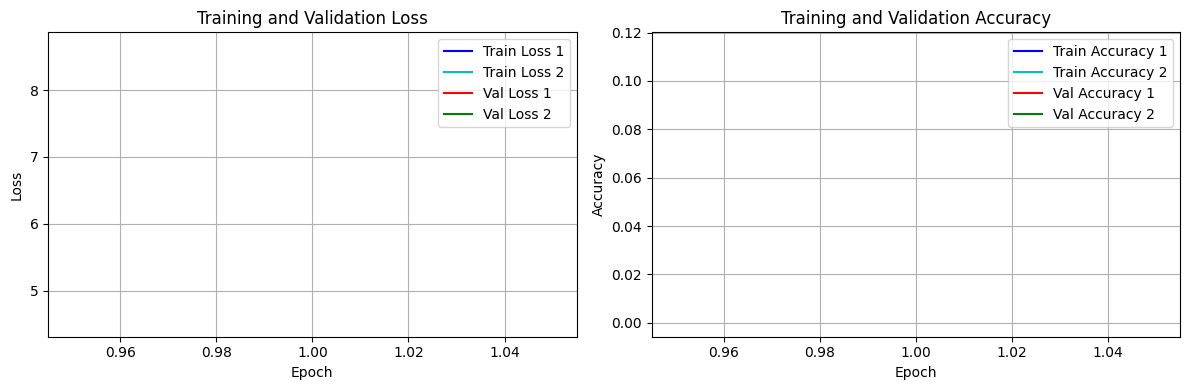

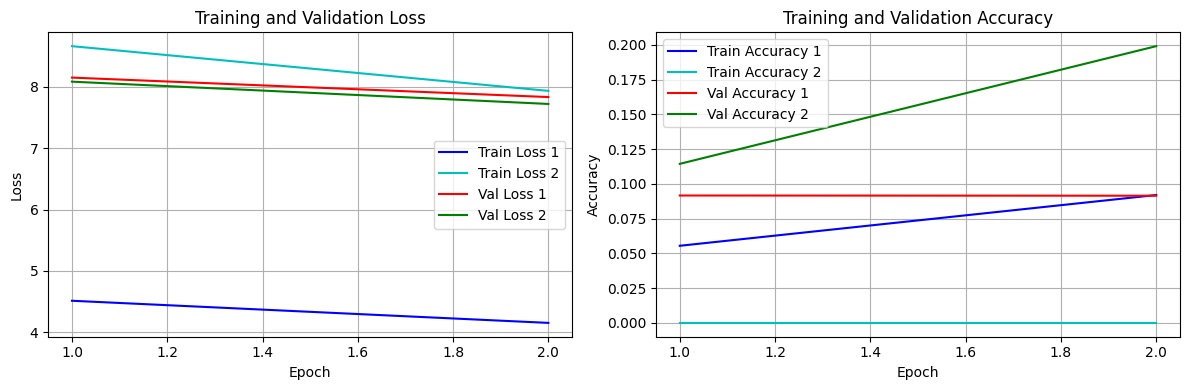

In [ ]:
# Step 1: Load both training datasets (C + C++) without vocab
temp_dataset_c = TokenizedCodeDataset("c_code_train.txt", vocab_size=10000)
temp_dataset_cpp = TokenizedCodeDataset("cpp_code_train.txt", vocab_size=10000)

# Step 2: Merge vocab counts and build shared vocab
all_tokens = Counter()
for seq in temp_dataset_c.sequences + temp_dataset_cpp.sequences:
    all_tokens.update(seq)

# Build shared vocab manually
special_tokens = ["<PAD>", "<UNK>", "<SOS>", "<EOS>"]
most_common = [tok for tok, _ in all_tokens.most_common(10000 - len(special_tokens))]
shared_vocab = special_tokens + most_common

dataloader_1, dataset1 = create_dataloader(
    file_path="c_code_train.txt",
    batch_size=8,
    max_seq_len=1000,
    vocab_size=None,   # ignored since we pass vocab
    vocab=shared_vocab
)

dataloader_2, dataset2 = create_dataloader(
    file_path="cpp_code_train.txt",
    batch_size=8,
    max_seq_len=1000,
    vocab=shared_vocab
)

valloader_1, dataset3 = create_dataloader(
    file_path="c_code_val.txt",
    batch_size=8,
    max_seq_len=1000,
    vocab=shared_vocab
)

valloader_2, dataset4 = create_dataloader(
    file_path="cpp_code_val.txt",
    batch_size=8,
    max_seq_len=1000,
    vocab=shared_vocab
)


model = Model1(src_vocab_size=len(dataset1.vocab),
        tgt_vocab_size=len(dataset1.vocab),
        d_model=256,
        nhead=4,
        num_encoder_layers=3,
        num_decoder_layers=3)

trainer = train_transformer(model, dataloader_1, dataloader_2, valloader_1, valloader_2, dataset1, 2)
